In [1]:
from __future__ import division, print_function
import numpy as np
import scipy as sc
from scipy import signal
from scipy.ndimage.filters import gaussian_filter
import math as math
from math import pi
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.ticker as mtick
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.ticker import FormatStrFormatter
import decimal
import sys
from numpy import genfromtxt
import glob
import datetime
import inspect
import os as os

%load_ext autoreload
%autoreload 2
%matplotlib inline

import seaborn as sns
sns.set(style='ticks', palette='Set2')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

/home/dslochower/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
from data_processing import *
from matrices import *
from flux import *

In [3]:
from debug_flux import *

In [4]:
def debug_TM(unbound, bound, energy_cat, k_cat_bin, kT,
                            dt=None, inter_surface_prefactor=1.0, intra_surface_prefactor=1.0):
    """
    This now returns a transition matrix along with printing the elements in three stages.
    """
    assert len(unbound) == len(bound)
    bins = len(unbound)
    energy_delta = bound - unbound
    transition_matrix = np.zeros((2 * bins, 2 * bins))

    transition_matrix[0:bins, 0:bins] = setup_rate_matrix(unbound, kT, intra_surface_prefactor)
    transition_matrix[bins:2 * bins, bins:2 * bins] = setup_rate_matrix(bound, kT, intra_surface_prefactor)

    transition_rates_unbound_to_bound = inter_surface_prefactor * np.exp(-1 * (bound - unbound) / float(2 * kT))
    transition_rates_bound_to_unbound = inter_surface_prefactor * np.exp(+1 * (bound - unbound) / float(2 * kT))

    transition_rates_bound_to_unbound[k_cat_bin] = inter_surface_prefactor * \
                                                   np.exp(+1 * (energy_delta[k_cat_bin] + 2 * energy_cat) / float(2 * kT))
    # !? Factor of 2 in catalytic energy because dividing by 2 kT !?

    for i in range(bins):
        transition_matrix[i, i + bins] = transition_rates_unbound_to_bound[i]
        transition_matrix[i + bins, i] = transition_rates_bound_to_unbound[i]

    # Note that these are writing j to i, reverse of the normal way.
    for j in range(2):
        for i in range(2):
            print('{0:0.2e} '.format(transition_matrix[i][j]), end="")
        print('')
        
        maximum_rate_constant_order = int(math.log10(transition_matrix.max()))

    if dt is not None:
        print('Using user supplied value for dt = {}'.format(dt))
    else:
        dt = 10 ** -(maximum_rate_constant_order + 1)
        print('Setting dt = {}'.format(dt))

    transition_matrix = np.multiply(transition_matrix, dt)
    
    print('')
    print('After multiplying by dt')
    print('')

    for j in range(2):
        for i in range(2):
            print('{0:0.2e} '.format(transition_matrix[i][j]), end="")
        print('')
        
    # row_sums = transition_matrix.sum(axis=0) # If I do this, I'm in agreement with Mike.
    row_sums = transition_matrix.sum(axis=1, keepdims=True)
    
    print('Row sums')
    print(row_sums)
    if np.any(row_sums > 1):
        print('Row sums unexpectedly greater than 1.')
        print(row_sums)
    for i in range(2 * bins):
        transition_matrix[i][i] = 1.0 - row_sums[i]
    # row_sums = transition_matrix.sum(axis=0)
    row_sums = transition_matrix.sum(axis=1, keepdims=True)

    
    print('')
    print('Filling in the diagonals')
    print('')
    for j in range(2):
        for i in range(2):
            print('{0:0.2e} '.format(transition_matrix[i][j]), end="")
        print('')

    return transition_matrix, dt
    

# This is Mike's 3-bin toy system.

In [5]:
dx = 1
kT = 1
unbound_energies = np.array([0, 1, 2])
bound_energies   = np.array([1, 2, 0])
     
bins = len(unbound_energies)
k_cat_bin = 0
energy_cat = 2
C_inter = 100
C_intra = 1e8
transition_matrix, dt = debug_TM(unbound_energies, bound_energies, energy_cat, k_cat_bin, kT,
                                                inter_surface_prefactor = C_inter, intra_surface_prefactor = C_intra)
eigenvalues, eigenvectors = np.linalg.eig(transition_matrix.T)
ss = eigenvectors[:, eigenvalues.argmax()].astype(float)
ss /= np.sum(ss)

print('The maximum eigenvalue is {}.'.format(max(eigenvalues)))

0.00e+00 1.65e+08 
6.07e+07 0.00e+00 
Setting dt = 1e-09

After multiplying by dt

0.00e+00 1.65e-01 
6.07e-02 0.00e+00 
Row sums
[[ 0.09744107]
 [ 0.22552525]
 [ 0.43670058]
 [ 0.22552641]
 [ 0.43670047]
 [ 0.09744105]]

Filling in the diagonals

9.03e-01 1.65e-01 
6.07e-02 7.74e-01 
The maximum eigenvalue is 1.0.


In [6]:
# # There are six terms that make up the flux calculation at any bin (`i`). These
# # terms take into account all the population coming into bin `i` (positive) and
# # all the population leaving bin `i`. The terms are:
# # Surface A: i --> i + 1            Negative
# # Surface A: i --> i - 1            Negative
# # Surface A: i + 1 --> i            Positive
# # Surface A: i - 1 --> i            Positive
# # Inter-surface A to B: i --> i     Negative
# # Inter-surface B to A: i --> i     Positive
# # There are special conditions for the boundaries, which have special "previous"
# # and "next" bins. The flux is calculated separately on both surfaces.
# flux_u = np.empty((bins))
# for i in range(bins):
#         if i == 0:
#             flux_u[i] = (
#                         - ss[i]           * transition_matrix[i][i + 1]/dt +
#                         - ss[i]           * transition_matrix[i][bins - 1]/dt +
#                         + ss[i + 1]       * transition_matrix[i + 1][i]/dt +
#                         + ss[bins - 1]    * transition_matrix[bins - 1][i]/dt +
#                         - ss[i]           * transition_matrix[i][i + bins]/dt +
#                         + ss[i + bins]    * transition_matrix[i + bins][i]/dt
#                         )
#         if i == bins - 1:
#             flux_u[i] = (
#                         - ss[i]        * transition_matrix[i][0]/dt +
#                         - ss[i]        * transition_matrix[i][i - 1]/dt +
#                         + ss[0]        * transition_matrix[0][i]/dt +
#                         + ss[i - 1]    * transition_matrix[i - 1][i]/dt +
#                         - ss[i]        * transition_matrix[i][i + bins]/dt +
#                         + ss[i + bins] * transition_matrix[i + bins][i]/dt
#                         )

#         else:
#             flux_u[i] = (
#                         - ss[i]        * transition_matrix[i][i + 1]/dt +
#                         - ss[i]        * transition_matrix[i][i - 1]/dt +
#                         + ss[i + 1]    * transition_matrix[i + 1][i]/dt +
#                         + ss[i - 1]    * transition_matrix[i - 1][i]/dt +
#                         - ss[i]        * transition_matrix[i][i + bins]/dt +
#                         + ss[i + bins] * transition_matrix[i + bins][i]/dt
#                         )
# flux_b = np.empty((bins))
# for i in range(bins, 2 * bins):
#         if i == bins:
#             flux_b[i - bins] = (
#                                - ss[i]            * transition_matrix[i][i + 1]/dt +
#                                - ss[i]            * transition_matrix[i][2 * bins - 1]/dt +
#                                + ss[i + 1]        * transition_matrix[i + 1][i]/dt +
#                                + ss[2 * bins - 1] * transition_matrix[2 * bins - 1][i]/dt +
#                                - ss[i]            * transition_matrix[i][i - bins]/dt +
#                                + ss[i - bins]     * transition_matrix[i - bins][i]/dt
#                                )
#         if i == 2 * bins - 1:
#             flux_b[i - bins] = (
#                                - ss[i]        * transition_matrix[i][bins]/dt +
#                                - ss[i]        * transition_matrix[i][i - 1]/dt +
#                                + ss[bins]     * transition_matrix[bins][i]/dt +
#                                + ss[i - 1]    * transition_matrix[i - 1][i]/dt +
#                                - ss[i]        * transition_matrix[i][i - bins]/dt +
#                                + ss[i - bins] * transition_matrix[i - bins][i]/dt
#                                )

#         else:
#             flux_b[i - bins] = (
#                                - ss[i]        * transition_matrix[i][i + 1]/dt +
#                                - ss[i]        * transition_matrix[i][i - 1]/dt +
#                                + ss[i + 1]    * transition_matrix[i + 1][i]/dt +
#                                + ss[i - 1]    * transition_matrix[i - 1][i]/dt +
#                                - ss[i]        * transition_matrix[i][i - bins]/dt +
#                                + ss[i - bins] * transition_matrix[i - bins][i]/dt
#                                )
# flux = np.concatenate((flux_u, flux_b))

In [7]:
# Flux across boundaries
flux_u = np.empty((bins))
for i in range(bins):
        if i == 0:
            flux_u[i] = (
                        - ss[i]           * transition_matrix[i][i + 1]/dt +
                        + ss[i + 1]       * transition_matrix[i + 1][i]/dt
                        )
        if i == bins - 1:
            flux_u[i] = (
                        - ss[i]        * transition_matrix[i][0]/dt +
                        + ss[0]        * transition_matrix[0][i]/dt
                        )

        else:
            flux_u[i] = (
                        - ss[i]        * transition_matrix[i][i + 1]/dt +
                        + ss[i + 1]    * transition_matrix[i + 1][i]/dt
                        )
flux_b = np.empty((bins))
for i in range(bins, 2 * bins):
        if i == bins:
            flux_b[i - bins] = (
                               - ss[i]            * transition_matrix[i][i + 1]/dt +
                               + ss[i + 1]        * transition_matrix[i + 1][i]/dt
                               )
        if i == 2 * bins - 1:
            flux_b[i - bins] = (
                               - ss[i]        * transition_matrix[i][bins]/dt +
                               + ss[bins]     * transition_matrix[bins][i]/dt
                               )

        else:
            flux_b[i - bins] = (
                               - ss[i]        * transition_matrix[i][i + 1]/dt +
                               + ss[i + 1]    * transition_matrix[i + 1][i]/dt
                               )
flux_ub = np.empty((bins))
for i in range(bins):
            flux_ub[i] = (
                         - ss[i]            * transition_matrix[i][i + bins]/dt +
                         + ss[i + bins]     * transition_matrix[i + bins][i]/dt
                         )
print('Flux from `i` to `i + 1` on unbound surface:')
print(flux_u)
print('Flux from `i` to `i + 1` on bound surface:')
print(flux_b)
print('Flux from `i` on unbound surface to bound surface:')
print(flux_ub)

Flux from `i` to `i + 1` on unbound surface:
[-12.11065225  -2.93700381  12.18778255]
Flux from `i` to `i + 1` on bound surface:
[  7.3454819   -1.82816656 -16.95295287]
Flux from `i` on unbound surface to bound surface:
[ 24.29843476  -9.17364846 -15.12478634]


In [143]:
(ss - np.dot(ss, transition_matrix)) / dt

array([  0.00000000e+00,   5.55111512e-08,  -2.77555756e-08,
        -1.38777878e-08,   0.00000000e+00,  -2.77555756e-08])

In [144]:
for i in range(1000):
        new_ss = np.dot(ss, transition_matrix)
        print('dp/dt = {}'.format((ss - new_ss)/dt))
        ss = new_ss

dp/dt = [  0.00000000e+00   5.55111512e-08  -2.77555756e-08  -1.38777878e-08
   0.00000000e+00  -2.77555756e-08]
dp/dt = [  0.00000000e+00   2.77555756e-08  -1.38777878e-08  -1.38777878e-08
   0.00000000e+00  -2.77555756e-08]
dp/dt = [  0.00000000e+00   2.77555756e-08   0.00000000e+00  -6.93889390e-09
  -3.46944695e-09  -2.77555756e-08]
dp/dt = [  0.00000000e+00   0.00000000e+00   0.00000000e+00  -1.38777878e-08
  -3.46944695e-09  -2.77555756e-08]
dp/dt = [  0.00000000e+00   0.00000000e+00   0.00000000e+00  -1.38777878e-08
  -3.46944695e-09  -2.77555756e-08]
dp/dt = [  0.00000000e+00   0.00000000e+00   0.00000000e+00  -6.93889390e-09
  -3.46944695e-09  -2.77555756e-08]
dp/dt = [  0.00000000e+00   0.00000000e+00   0.00000000e+00  -6.93889390e-09
  -3.46944695e-09  -2.77555756e-08]
dp/dt = [  0.00000000e+00   0.00000000e+00   0.00000000e+00  -1.38777878e-08
  -3.46944695e-09  -2.77555756e-08]
dp/dt = [  0.00000000e+00   0.00000000e+00   0.00000000e+00  -6.93889390e-09
  -6.93889390e-09  

In [145]:
# Flux acronew_ss boundaries
flux_u = np.empty((bins))
for i in range(bins):
        if i == 0:
            flux_u[i] = (
                        - new_ss[i]           * transition_matrix[i][i + 1]/dt +
                        + new_ss[i + 1]       * transition_matrix[i + 1][i]/dt
                        )
        if i == bins - 1:
            flux_u[i] = (
                        - new_ss[i]        * transition_matrix[i][0]/dt +
                        + new_ss[0]        * transition_matrix[0][i]/dt
                        )

        else:
            flux_u[i] = (
                        - new_ss[i]        * transition_matrix[i][i + 1]/dt +
                        + new_ss[i + 1]    * transition_matrix[i + 1][i]/dt
                        )
flux_b = np.empty((bins))
for i in range(bins, 2 * bins):
        if i == bins:
            flux_b[i - bins] = (
                               - new_ss[i]            * transition_matrix[i][i + 1]/dt +
                               + new_ss[i + 1]        * transition_matrix[i + 1][i]/dt
                               )
        if i == 2 * bins - 1:
            flux_b[i - bins] = (
                               - new_ss[i]        * transition_matrix[i][bins]/dt +
                               + new_ss[bins]     * transition_matrix[bins][i]/dt
                               )

        else:
            flux_b[i - bins] = (
                               - new_ss[i]        * transition_matrix[i][i + 1]/dt +
                               + new_ss[i + 1]    * transition_matrix[i + 1][i]/dt
                               )
flux_ub = np.empty((bins))
for i in range(bins):
            flux_ub[i] = (
                         - new_ss[i]            * transition_matrix[i][i + bins]/dt +
                         + new_ss[i + bins]     * transition_matrix[i + bins][i]/dt
                         )
print('Flux from `i` to `i + 1` on unbound surface:')
print(flux_u)
print('Flux from `i` to `i + 1` on bound surface:')
print(flux_b)
print('Flux from `i` on unbound surface to bound surface:')
print(flux_ub)

Flux from `i` to `i + 1` on unbound surface:
[-12.11065226  -2.9370038   12.18778254]
Flux from `i` to `i + 1` on bound surface:
[  7.3454819   -1.82816656 -16.95295287]
Flux from `i` on unbound surface to bound surface:
[ 24.29843476  -9.17364846 -15.12478634]


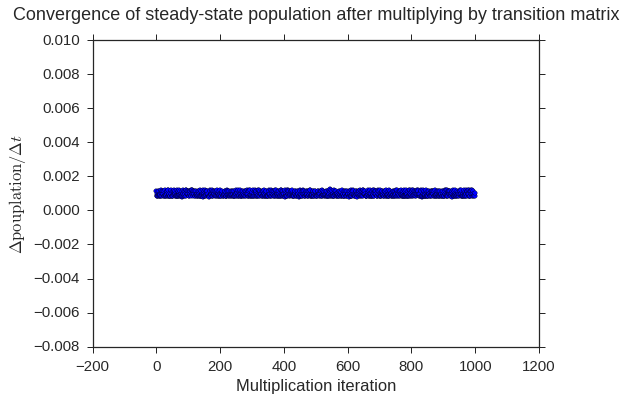

In [100]:
plt.figure()
for i in range(1000):
        new_ss = np.dot(ss, transition_matrix)
#         print('dp/dt = {}'.format((ss - new_ss)/dt))
        plt.scatter(i, np.sum( (ss - new_ss)/dt))
        ss = new_ss
# plt.ylim([0.0007, 0.0015])
plt.title('Convergence of steady-state population after multiplying by transition matrix', y=1.05)
plt.xlabel('Multiplication iteration')
plt.ylabel('$\Delta \mathrm{pouplation} / \Delta t$')
plt.show()

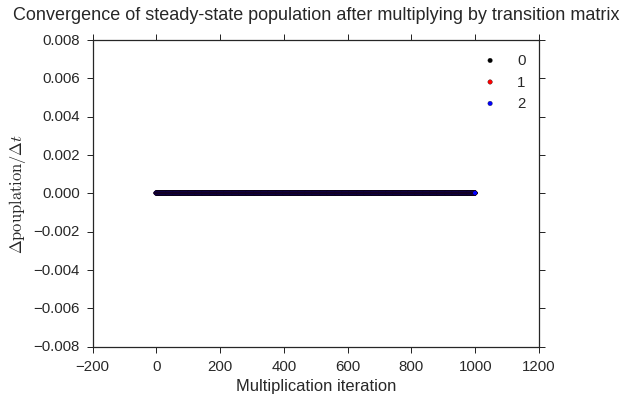

In [95]:
plt.figure()
for i in range(1000):
        new_ss = np.dot(ss, transition_matrix)
#         print('dp/dt = {}'.format((ss - new_ss)/dt))
        plt.scatter(i, (ss[0] - new_ss[0])/dt, c='k', label='0' if i == 0 else '')
        plt.scatter(i, (ss[1] - new_ss[1])/dt, c='r', label='1' if i == 0 else '')
        plt.scatter(i, (ss[2] - new_ss[2])/dt, c='b', label='2' if i == 0 else '')
        ss = new_ss
#plt.ylim([0.0007, 0.0015])
plt.title('Convergence of steady-state population after multiplying by transition matrix', y=1.05)
plt.xlabel('Multiplication iteration')
plt.ylabel('$\Delta \mathrm{pouplation} / \Delta t$')
plt.legend()
plt.show()

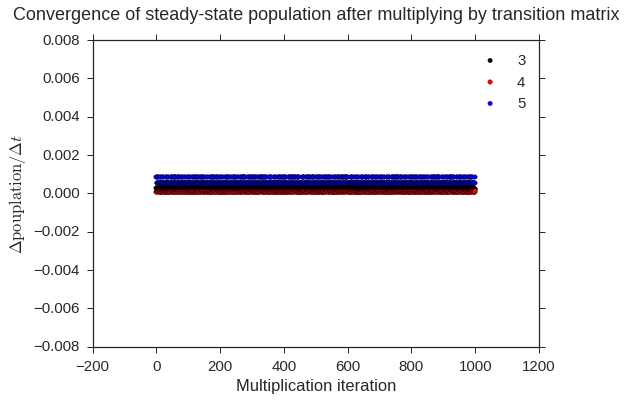

In [96]:
plt.figure()
for i in range(1000):
        new_ss = np.dot(ss, transition_matrix)
#         print('dp/dt = {}'.format((ss - new_ss)/dt))
        plt.scatter(i, (ss[3] - new_ss[3])/dt, c='k', label='3' if i == 0 else '')
        plt.scatter(i, (ss[4] - new_ss[4])/dt, c='r', label='4' if i == 0 else '')
        plt.scatter(i, (ss[5] - new_ss[5])/dt, c='b', label='5' if i == 0 else '')
        ss = new_ss
#plt.ylim([0.0007, 0.0015])
plt.title('Convergence of steady-state population after multiplying by transition matrix', y=1.05)
plt.xlabel('Multiplication iteration')
plt.ylabel('$\Delta \mathrm{pouplation} / \Delta t$')
plt.legend()
plt.show()

In [98]:
np.sum(new_ss)

0.99999999999865674

In [107]:
np.sum(ss)

1.0000000000000417

In [106]:
-.861274E-07 + -.313421E-07 + -.112765E-07 + 0.162782E-07 + -.114988E-07 +  0.123967E-06

3.999999999951596e-13

In [27]:

def intra_rate(energies, bin_from, bin_to):
    return C_intra * np.exp(-energies[bin_to] - energies[bin_from] / 2 * kT)

def inter_rate(unbound, bound, bin):
    return C_inter * np.exp(-bound[bin] - unbound[bin] / 2 * kT)

def Mikes_R(unbound, bound, energy_cat, k_cat_bin, kT,
                            dt=None, inter_surface_prefactor=1.0, intra_surface_prefactor=1.0):
    assert len(unbound) == len(bound)
    bins = len(unbound)
    energy_delta = bound - unbound

    rate_matrix = np.zeros((2 * bins, 2 * bins))

    # Build up the diagonals.
    # Boundary condition.
    rate_matrix[0][0] = (- intra_rate(unbound, 0, 1)
                         - intra_rate(unbound, 0, bins - 1)
                         - inter_rate(unbound, bound, 0))
    # Boundary condition.
    rate_matrix[bins - 1][bins - 1] = (- intra_rate(unbound, bins - 1, 0)
                               - intra_rate(unbound, bins - 1, bins - 2)
                               - inter_rate(unbound, bound, bins - 1))
    # Loop over interior.
    for i in range(bins - 1):
        rate_matrix[i][i] = (- intra_rate(unbound, i, i + 1)
                             - intra_rate(unbound, i, i - 1)
                             - inter_rate(unbound, bound, i))
    return rate_matrix

In [28]:
Mikes_R(unbound_energies, bound_energies, 0, 0, kT)

array([[-50321509.22874962,         0.        ,         0.        ,
                0.        ,         0.        ,         0.        ],
       [        0.        , -68861574.04215309,         0.        ,
                0.        ,         0.        ,         0.        ],
       [        0.        ,         0.        , -50321509.22874962,
                0.        ,         0.        ,         0.        ],
       [        0.        ,         0.        ,         0.        ,
                0.        ,         0.        ,         0.        ],
       [        0.        ,         0.        ,         0.        ,
                0.        ,         0.        ,         0.        ],
       [        0.        ,         0.        ,         0.        ,
                0.        ,         0.        ,         0.        ]])

# CHris' Arginine

In [38]:
dx = 1
kT = 1

unbound_files=['chi1ARG130.ene']
energies = genfromtxt(unbound_files[0], delimiter='\t')

unbound_energies = energies[:, 0]
bound_energies = energies[:, 1]

bins = len(unbound_energies)
k_cat_bin = 0
energy_cat = 2
C_inter = 100
C_intra = 1e8
transition_matrix, dt = debug_TM(unbound_energies, bound_energies, energy_cat, k_cat_bin, kT,
                                                inter_surface_prefactor = C_inter, intra_surface_prefactor = C_intra)
eigenvalues, eigenvectors = np.linalg.eig(transition_matrix.T)
ss = eigenvectors[:, eigenvalues.argmax()].astype(float)
ss /= np.sum(ss)

print('The maximum eigenvalue is {}.'.format(max(eigenvalues)))

0.00e+00 1.00e+08 
1.00e+08 0.00e+00 
Setting dt = 1e-09

After multiplying by dt

0.00e+00 1.00e-01 
1.00e-01 0.00e+00 
Row sums
[[ 0.20000008]
 [ 0.20000008]
 [ 0.20000008]
 [ 0.20000008]
 [ 0.20000013]
 [ 0.20000079]
 [ 0.24142427]
 [ 0.65050413]
 [ 0.37071579]
 [ 0.24707225]
 [ 0.18502164]
 [ 0.16649884]
 [ 0.18506378]
 [ 0.21413546]
 [ 0.18630226]
 [ 0.18366866]
 [ 0.24209752]
 [ 0.36684621]
 [ 0.67546746]
 [ 0.20000383]
 [ 0.79365464]
 [ 0.4646065 ]
 [ 0.35466859]
 [ 0.2960535 ]
 [ 0.26965469]
 [ 0.25073953]
 [ 0.23071546]
 [ 0.21456958]
 [ 0.2012909 ]
 [ 0.19129756]
 [ 0.18583667]
 [ 0.18519483]
 [ 0.18965519]
 [ 0.1989449 ]
 [ 0.21184207]
 [ 0.22541534]
 [ 0.23440593]
 [ 0.24006841]
 [ 0.24022814]
 [ 0.23388327]
 [ 0.31013143]
 [ 0.27584396]
 [ 0.23387062]
 [ 0.22105441]
 [ 0.2091154 ]
 [ 0.19695919]
 [ 0.18778502]
 [ 0.18462318]
 [ 0.18599158]
 [ 0.19293488]
 [ 0.2060282 ]
 [ 0.22302405]
 [ 0.23725134]
 [ 0.25960755]
 [ 0.27595787]
 [ 0.180783  ]
 [ 0.17780443]
 [ 0.24052606]


In [39]:
# Flux across boundaries
flux_u = np.empty((bins))
for i in range(bins):
        if i == 0:
            flux_u[i] = (
                        - ss[i]           * transition_matrix[i][i + 1]/dt +
                        + ss[i + 1]       * transition_matrix[i + 1][i]/dt
                        )
        if i == bins - 1:
            flux_u[i] = (
                        - ss[i]        * transition_matrix[i][0]/dt +
                        + ss[0]        * transition_matrix[0][i]/dt
                        )

        else:
            flux_u[i] = (
                        - ss[i]        * transition_matrix[i][i + 1]/dt +
                        + ss[i + 1]    * transition_matrix[i + 1][i]/dt
                        )
flux_b = np.empty((bins))
for i in range(bins, 2 * bins):
        if i == bins:
            flux_b[i - bins] = (
                               - ss[i]            * transition_matrix[i][i + 1]/dt +
                               + ss[i + 1]        * transition_matrix[i + 1][i]/dt
                               )
        if i == 2 * bins - 1:
            flux_b[i - bins] = (
                               - ss[i]        * transition_matrix[i][bins]/dt +
                               + ss[bins]     * transition_matrix[bins][i]/dt
                               )

        else:
            flux_b[i - bins] = (
                               - ss[i]        * transition_matrix[i][i + 1]/dt +
                               + ss[i + 1]    * transition_matrix[i + 1][i]/dt
                               )
flux_ub = np.empty((bins))
for i in range(bins):
            flux_ub[i] = (
                         - ss[i]            * transition_matrix[i][i + bins]/dt +
                         + ss[i + bins]     * transition_matrix[i + bins][i]/dt
                         )
print('Flux from `i` to `i + 1` on unbound surface:')
print(flux_u)
print('Flux from `i` to `i + 1` on bound surface:')
print(flux_b)
print('Flux from `i` on unbound surface to bound surface:')
print(flux_ub)

Flux from `i` to `i + 1` on unbound surface:
[ -1.12126790e-07  -6.87425261e-08  -1.51849240e-08  -3.97120930e-08
  -2.22660436e-08  -9.19207868e-09  -9.43128705e-08  -9.38521763e-08
  -1.09843398e-07  -1.62466904e-07  -2.93981657e-07  -3.88436547e-07
  -4.22023504e-07  -3.62449441e-07  -3.88941316e-07  -3.80586499e-07
  -4.59540335e-07  -4.08147468e-07  -3.80008814e-07  -3.96782913e-07
  -3.44164892e-07  -3.67933133e-07  -3.89036700e-07  -3.03249180e-07
  -4.07540938e-07  -2.34955223e-07  -2.33645551e-07  -6.19329512e-08
   1.23865902e-07   4.25614417e-07   8.43778253e-07   1.31689012e-06
   1.80304050e-06   1.90036371e-06   1.78162009e-06   1.72608998e-06
   1.68310362e-06   1.66549580e-06   1.70517342e-06   1.66056589e-06
   1.66228847e-06   1.69408486e-06   1.65044548e-06   1.52528810e-06
   1.44224032e-06   1.43685611e-06   1.29360706e-06   1.35082519e-06
   1.32137211e-06   1.22361234e-06   1.05125946e-06   9.74916475e-07
   9.66153493e-07   9.03720320e-07   8.60500109e-07   9.78

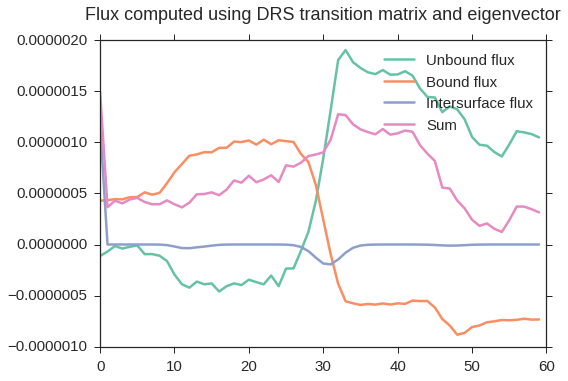

In [41]:
plt.figure()
plt.plot(range(bins), flux_u, label='Unbound flux')
plt.plot(range(bins), flux_b, label='Bound flux')
plt.plot(range(bins), flux_ub, label='Intersurface flux')
plt.plot(range(bins), flux_u + flux_b + flux_ub, label='Sum')
plt.title('Flux computed using DRS transition matrix and eigenvector', y=1.05)
plt.legend()
plt.show()

## Reference with zero catalysis

In [16]:
# dx = 1
# kT = 1
# dx = 1
# kT = 1

# unbound_files=['chi1ARG130.ene']
# energies = genfromtxt(unbound_files[0], delimiter='\t')

# unbound_energies = energies[:, 0]
# bound_energies = energies[:, 1]

# bins = len(unbound_energies)
# k_cat_bin = 0
# ################
# energy_cat = 0
# ################
# C_inter = 100
# C_intra = 1e8
# transition_matrix, dt = debug_TM(unbound_energies, bound_energies, energy_cat, k_cat_bin, kT,
#                                                 inter_surface_prefactor = C_inter, intra_surface_prefactor = C_intra)
# eigenvalues, eigenvectors = np.linalg.eig(transition_matrix.T)
# ss = eigenvectors[:, eigenvalues.argmax()].astype(float)
# ss /= np.sum(ss)

# print('The maximum eigenvalue is {}.'.format(max(eigenvalues)))

In [71]:
# Flux across boundaries
flux_u = np.empty((bins))
for i in range(bins):
        if i == 0:
            flux_u[i] = (
                        - ss[i]           * transition_matrix[i][i + 1]/dt +
                        + ss[i + 1]       * transition_matrix[i + 1][i]/dt
                        )
        if i == bins - 1:
            flux_u[i] = (
                        - ss[i]        * transition_matrix[i][0]/dt +
                        + ss[0]        * transition_matrix[0][i]/dt
                        )

        else:
            flux_u[i] = (
                        - ss[i]        * transition_matrix[i][i + 1]/dt +
                        + ss[i + 1]    * transition_matrix[i + 1][i]/dt
                        )
flux_b = np.empty((bins))
for i in range(bins, 2 * bins):
        if i == bins:
            flux_b[i - bins] = (
                               - ss[i]            * transition_matrix[i][i + 1]/dt +
                               + ss[i + 1]        * transition_matrix[i + 1][i]/dt
                               )
        if i == 2 * bins - 1:
            flux_b[i - bins] = (
                               - ss[i]        * transition_matrix[i][bins]/dt +
                               + ss[bins]     * transition_matrix[bins][i]/dt
                               )

        else:
            flux_b[i - bins] = (
                               - ss[i]        * transition_matrix[i][i + 1]/dt +
                               + ss[i + 1]    * transition_matrix[i + 1][i]/dt
                               )
flux_ub = np.empty((bins))
for i in range(bins):
            flux_ub[i] = (
                         - ss[i]            * transition_matrix[i][i + bins]/dt +
                         + ss[i + bins]     * transition_matrix[i + bins][i]/dt
                         )
print('Flux from `i` to `i + 1` on unbound surface:')
print(flux_u)
print('Flux from `i` to `i + 1` on bound surface:')
print(flux_b)
print('Flux from `i` on unbound surface to bound surface:')
print(flux_ub)

Flux from `i` to `i + 1` on unbound surface:
[ -4.28987017e-07  -2.92787258e-07  -2.35185631e-07  -9.44359576e-08
  -8.61792998e-08  -5.35062279e-08  -3.87109639e-08  -2.96605838e-08
  -1.70989978e-08   6.90224624e-08   1.76163439e-07   3.11397343e-07
   4.67964355e-07   5.40538508e-07   6.84571546e-07   7.13319054e-07
   7.38124896e-07   7.14803656e-07   7.26841566e-07   7.80783774e-07
   7.46609349e-07   8.27466188e-07   8.47849265e-07   7.94004336e-07
   9.15671990e-07   8.91654054e-07   9.67644155e-07   9.42498446e-07
   6.77071512e-07   1.26659870e-07  -5.12227416e-07  -1.09151006e-06
  -1.53854489e-06  -1.72667205e-06  -1.88406557e-06  -1.86049147e-06
  -1.80196366e-06  -1.73252556e-06  -1.71718239e-06  -1.75956802e-06
  -1.72466457e-06  -1.85370482e-06  -1.90199717e-06  -1.81633368e-06
  -1.83208613e-06  -1.92632433e-06  -1.98360067e-06  -1.87061960e-06
  -1.57934846e-06  -1.28918327e-06  -1.21095218e-06  -1.07485175e-06
  -1.00364014e-06  -9.18545538e-07  -9.30961278e-07  -7.43

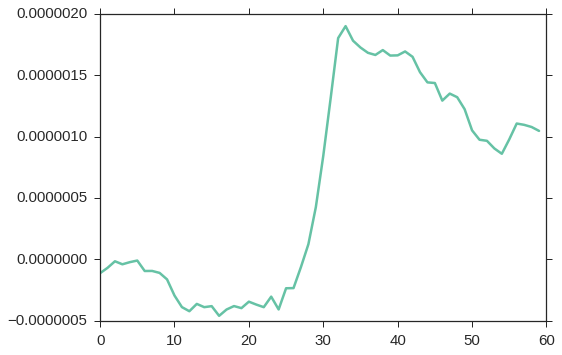

In [109]:
plt.figure()
plt.plot(range(bins), flux_u)
plt.show()

In [18]:
mike_flux_u = genfromtxt('/home/dslochower/Downloads/mike_flux_u', delimiter=' ')
mike_flux_b = genfromtxt('/home/dslochower/Downloads/mike_flux_b', delimiter=' ')


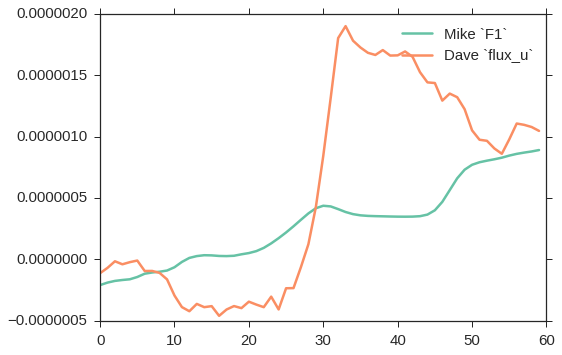

In [20]:
plt.figure()
plt.plot(range(bins), mike_flux_u, label='Mike `F1`')
plt.plot(range(bins), flux_u, label='Dave `flux_u`')
plt.legend()
plt.show()

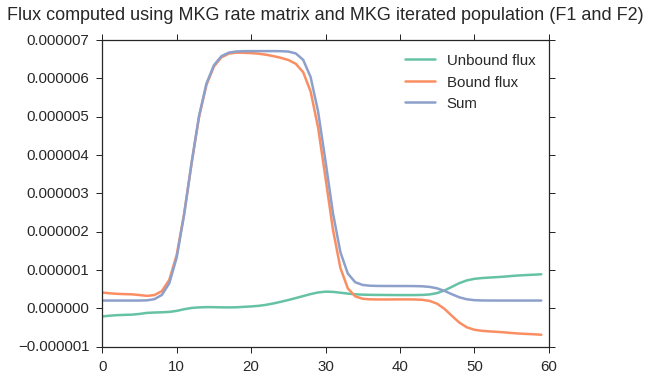

In [30]:
plt.figure()
plt.plot(range(bins), mike_flux_u, label='Unbound flux')
plt.plot(range(bins), mike_flux_b, label='Bound flux')
plt.plot(range(bins), mike_flux_u + mike_flux_b, label='Sum')
plt.title('Flux computed using MKG rate matrix and MKG iterated population (F1 and F2)', y=1.05)
plt.legend()
plt.show()

## Read in Mike's rate matrix

In [23]:
# mike_matrix = genfromtxt('/home/dslochower/Downloads/chi1-0-2-1e8-100.mtx', delimiter='    ')
mike_matrix = genfromtxt('/home/dslochower/Downloads/chi1-precise.mtx', delimiter=' ')
print(mike_matrix)

[[  9.97116706e-01   1.44164296e-03   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.44164296e-03   9.97116713e-01   1.44164296e-03 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   1.44164296e-03   9.97116713e-01 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   9.94349147e-01
    8.66371669e-03   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   2.39889472e-04
    9.89894629e-01   1.44164296e-03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    1.44164296e-03   9.97116712e-01]]


In [24]:
dx = 1
kT = 1

mike_eigenvalues, mike_eigenvectors = np.linalg.eig(mike_matrix)
mike_ss = mike_eigenvectors[:, mike_eigenvalues.argmax()].astype(float)
mike_ss /= np.sum(mike_ss)

print('The maximum eigenvalue is {}.'.format(max(mike_eigenvalues)))

The maximum eigenvalue is 0.999999999999998.


In [25]:
mike_eigenvalues

array([ 0.98789715,  0.98919328,  0.98954913,  0.98983407,  0.98975573,
        0.98959274,  0.9913989 ,  0.99248031,  0.99977987,  0.99964063,
        0.99999938,  0.99999968,  1.        ,  1.        ,  0.99999996,
        0.99999989,  0.99964608,  0.99950575,  0.99959424,  0.99955029,
        0.99958928,  0.99954374,  0.99953608,  0.99928226,  0.99916024,
        0.99915334,  0.9993148 ,  0.99342048,  0.99928903,  0.99351209,
        0.99350432,  0.99900732,  0.99915543,  0.99907473,  0.99357218,
        0.99355497,  0.99892993,  0.99876705,  0.99375476,  0.99886247,
        0.99374459,  0.99864895,  0.99861835,  0.99870997,  0.9985236 ,
        0.99391932,  0.9940056 ,  0.99402211,  0.99837301,  0.99824971,
        0.99822089,  0.99849785,  0.99847655,  0.9939781 ,  0.99830742,
        0.99391996,  0.99398889,  0.99813952,  0.99798362,  0.99411345,
        0.99801011,  0.99784417,  0.997809  ,  0.9943256 ,  0.99421748,
        0.99438069,  0.99764338,  0.997892  ,  0.99757414,  0.99

In [215]:
mike_eigenvalues > 0.99999999

array([False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False], dtype=bool)

In [216]:
mike_eigenvectors[:, mike_eigenvalues > 0.99999999]

array([[ -9.01911847e-09,   8.42500213e-09],
       [ -9.01821465e-09,   7.92810779e-09],
       [ -9.01728566e-09,   7.43128165e-09],
       [ -9.01681477e-09,   6.93428544e-09],
       [ -9.01677972e-09,   6.43709181e-09],
       [ -9.01726708e-09,   5.93960170e-09],
       [ -9.01814045e-09,   5.44208013e-09],
       [ -1.80375962e-08,   1.01812770e-08],
       [ -6.06347517e-07,   3.39374950e-07],
       [ -7.57562044e-06,   4.23840334e-06],
       [ -3.62605535e-05,   2.02861652e-05],
       [ -7.03750342e-05,   3.93715112e-05],
       [ -6.31364571e-05,   3.53221789e-05],
       [ -3.98900154e-05,   2.23174295e-05],
       [ -3.11207299e-05,   1.74123053e-05],
       [ -1.66232327e-05,   9.30192088e-06],
       [ -3.64749801e-06,   2.04181092e-06],
       [ -2.98664826e-07,   1.67671986e-07],
       [ -9.01899636e-09,   5.35912877e-09],
       [ -9.01965929e-09,   7.06299342e-09],
       [ -9.02024591e-09,   8.76743112e-09],
       [ -4.34016742e-07,   4.33673782e-07],
       [ -

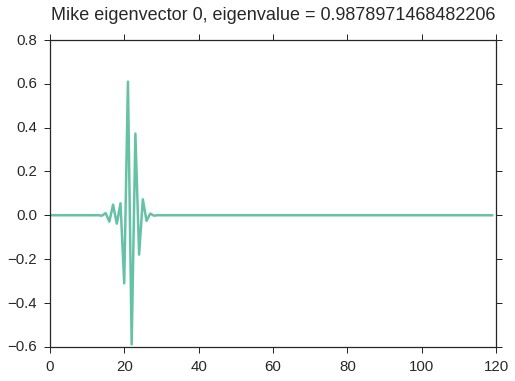

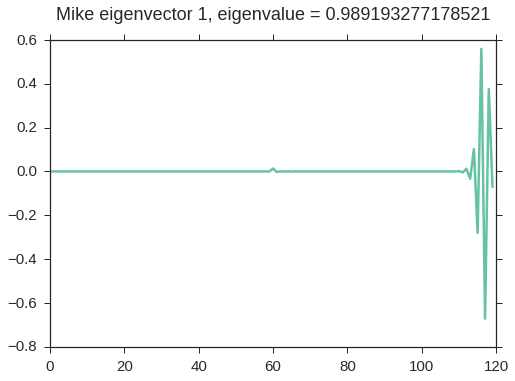

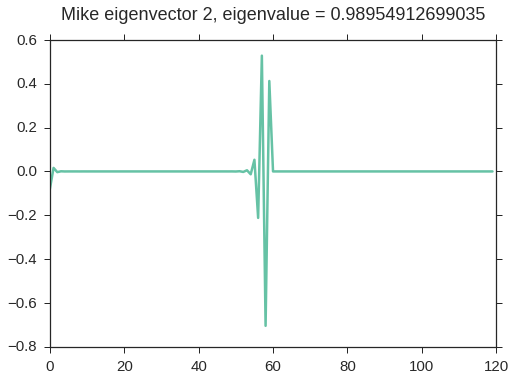

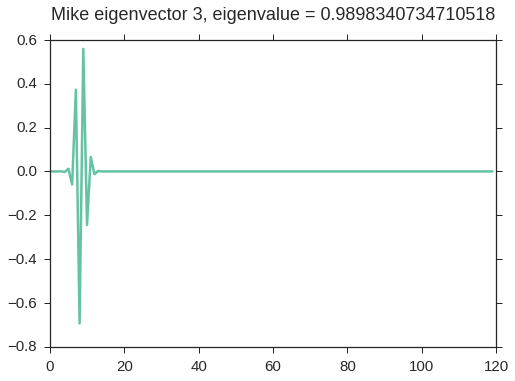

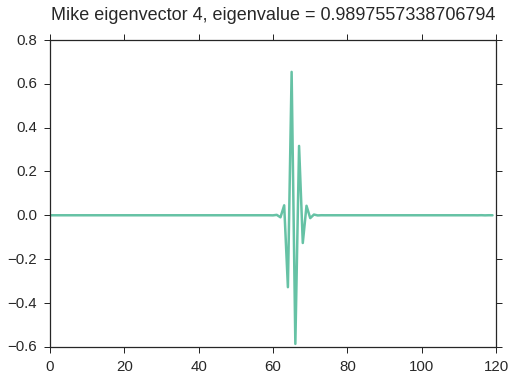

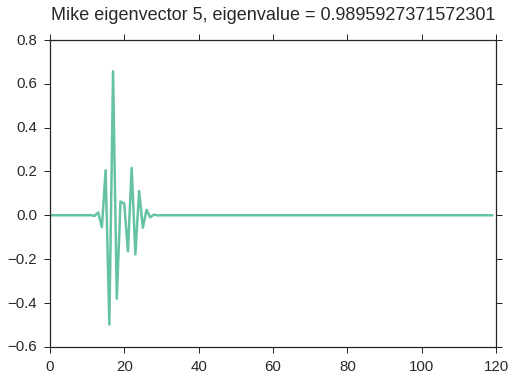

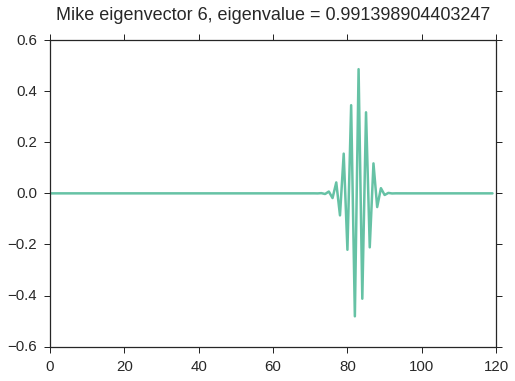

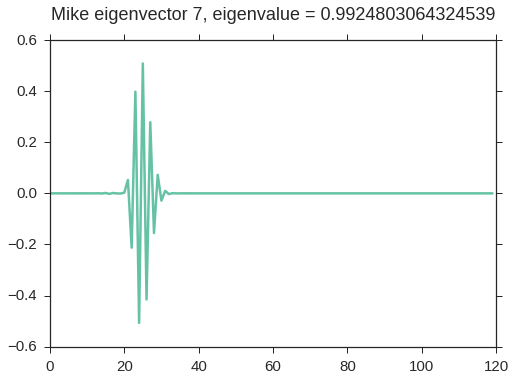

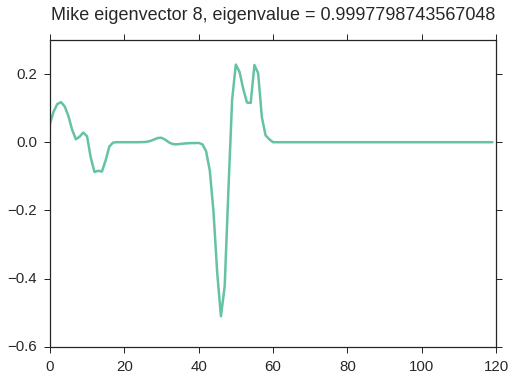

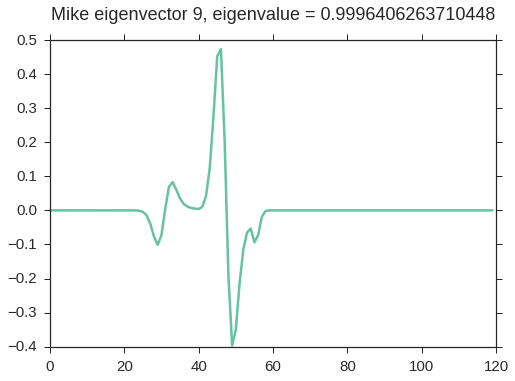

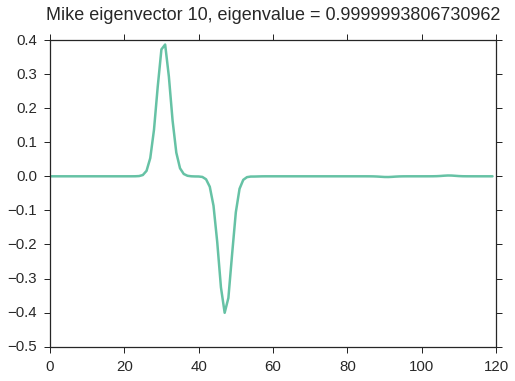

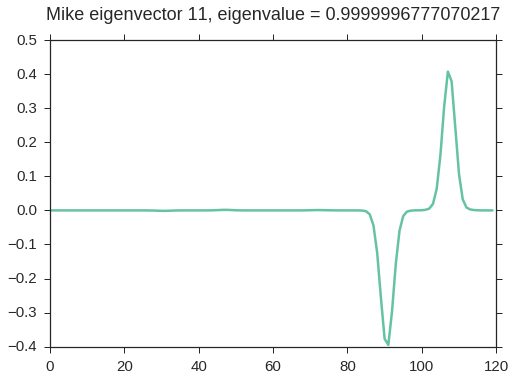

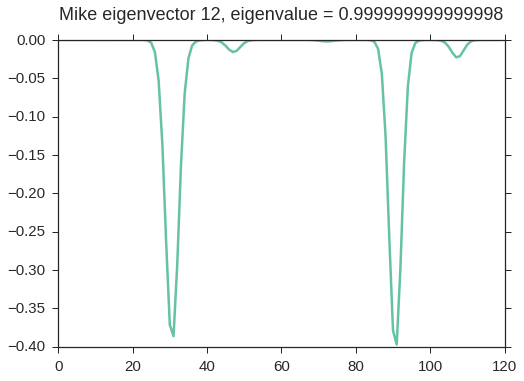

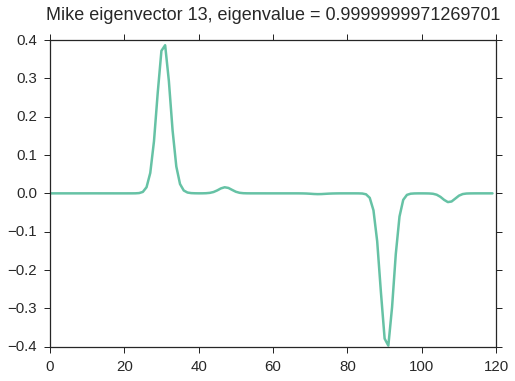

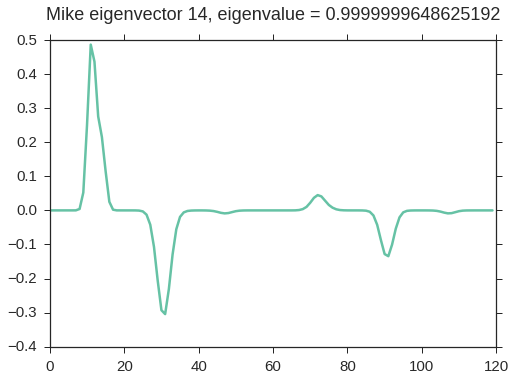

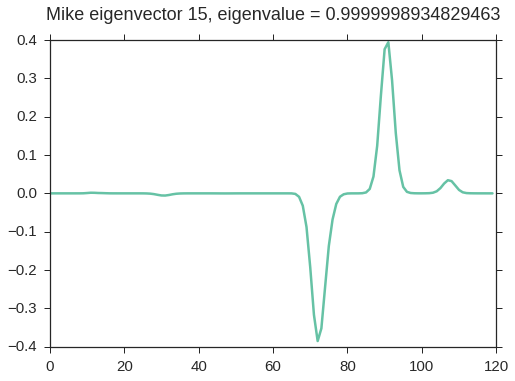

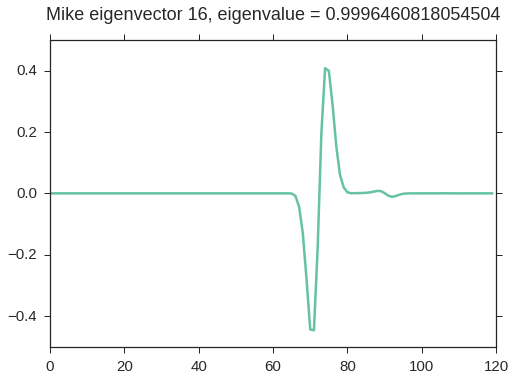

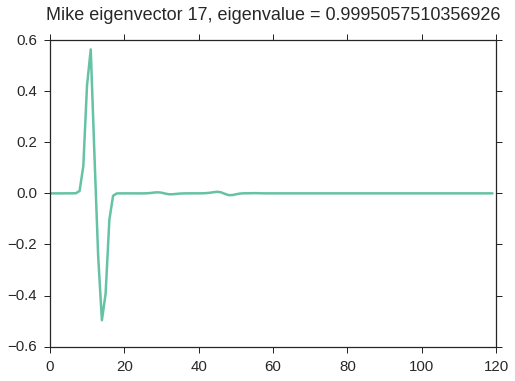

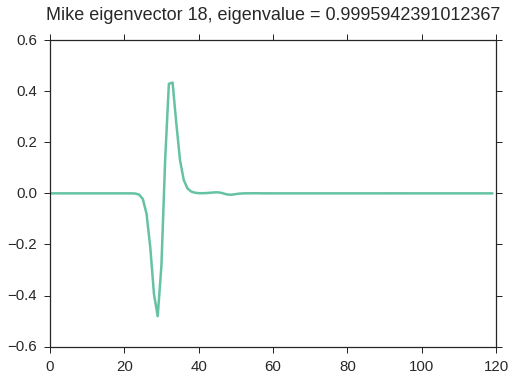

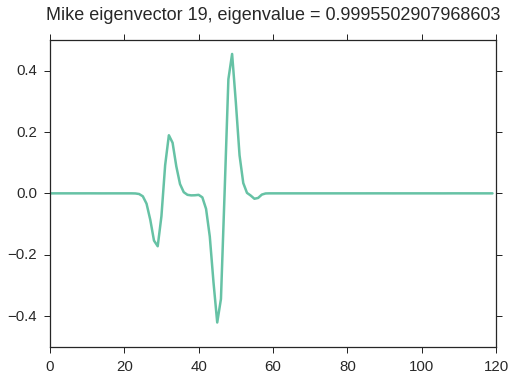

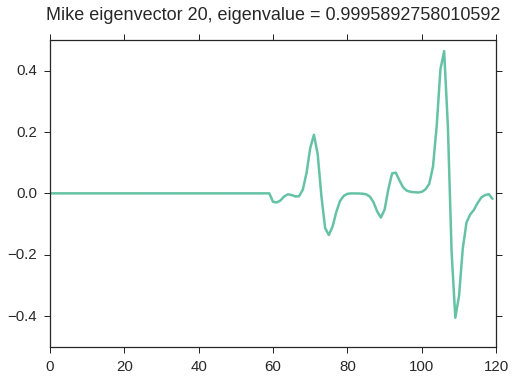

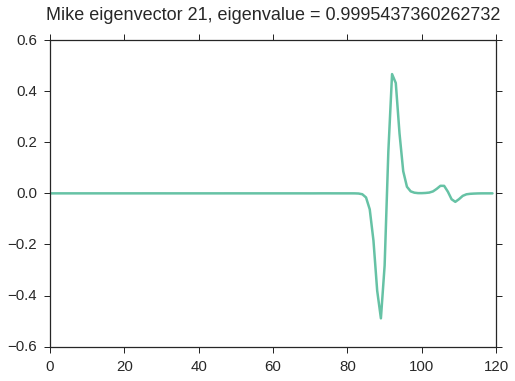

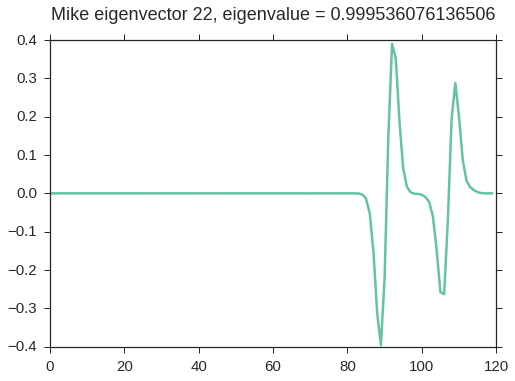

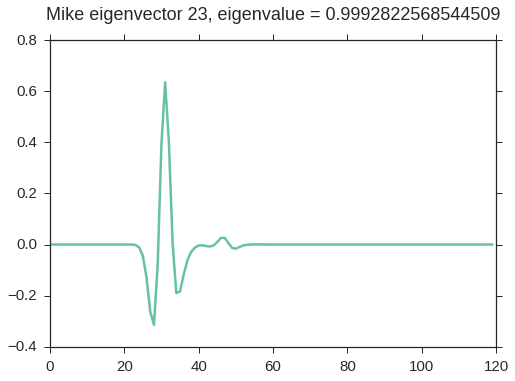

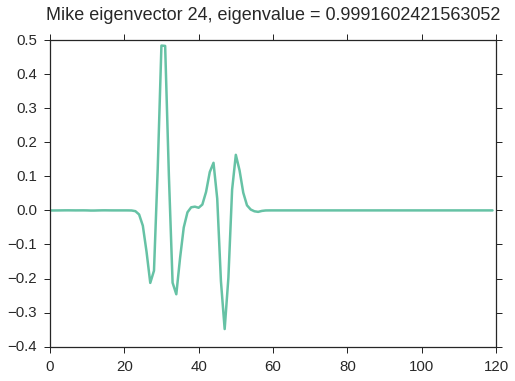

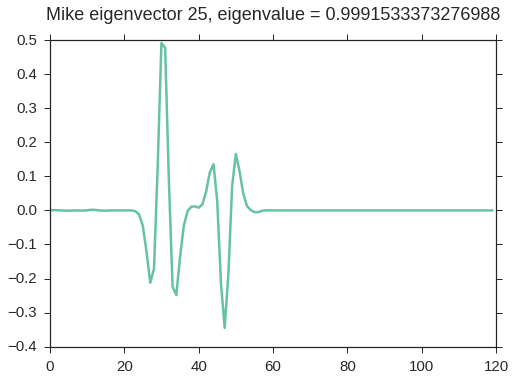

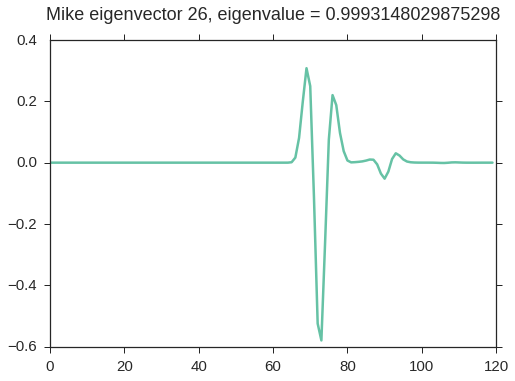

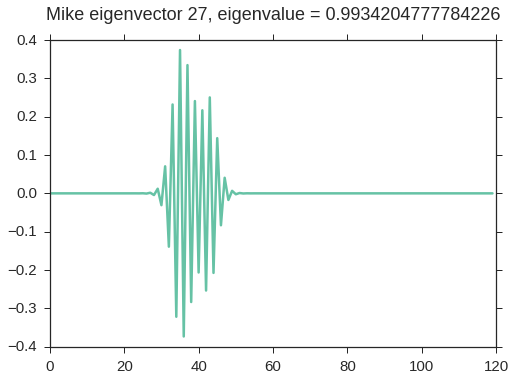

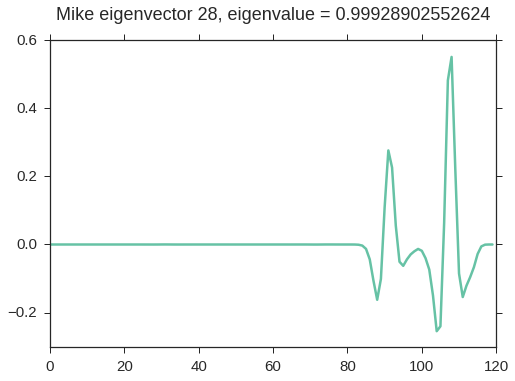

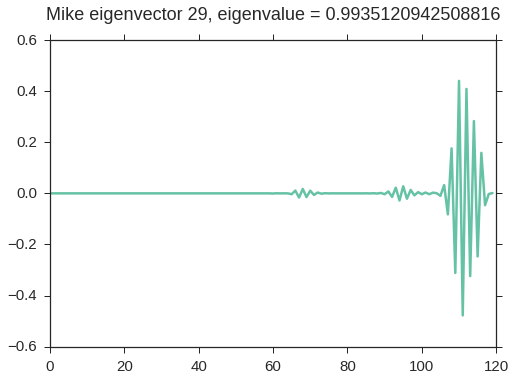

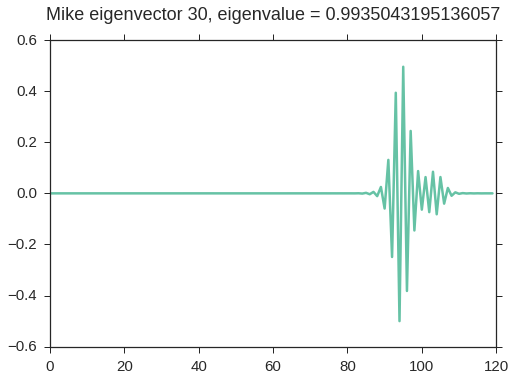

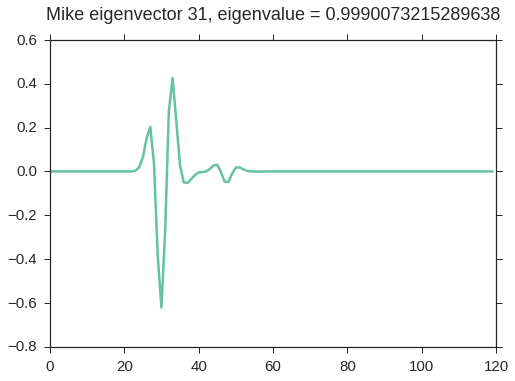

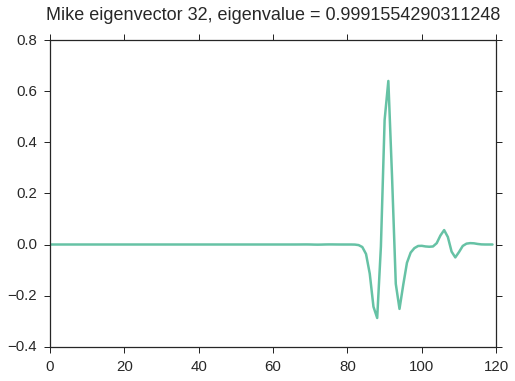

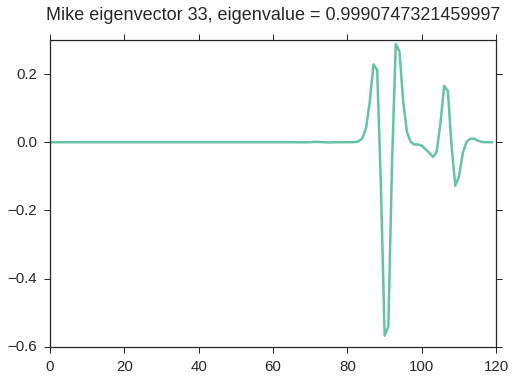

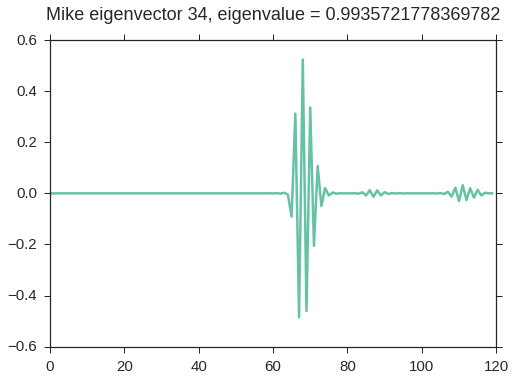

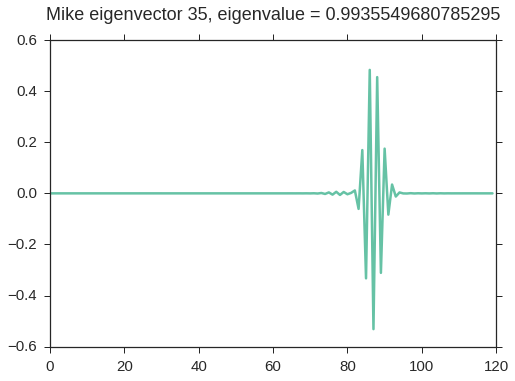

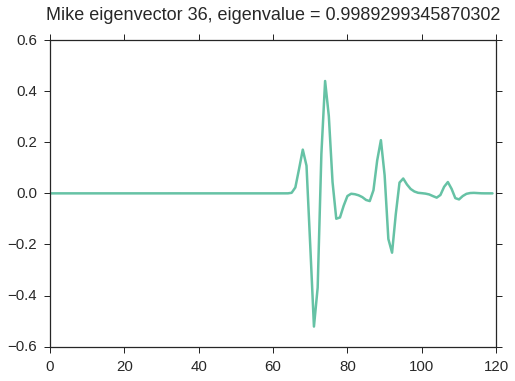

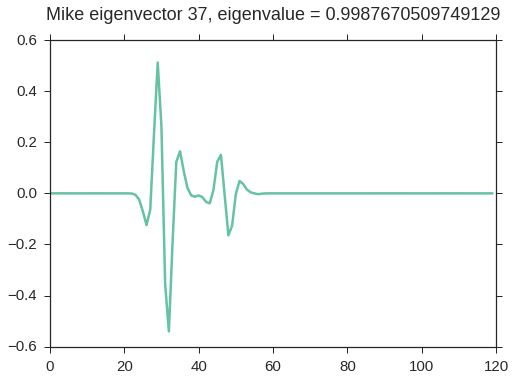

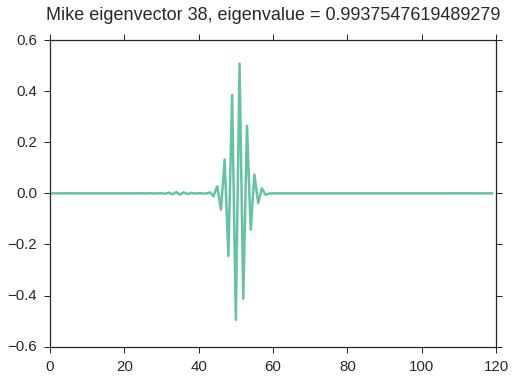

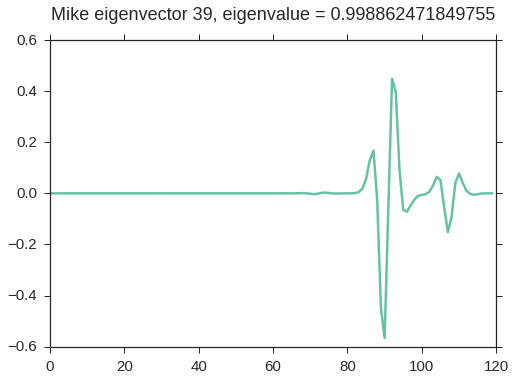

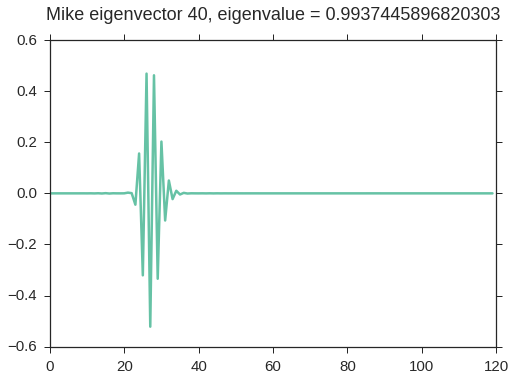

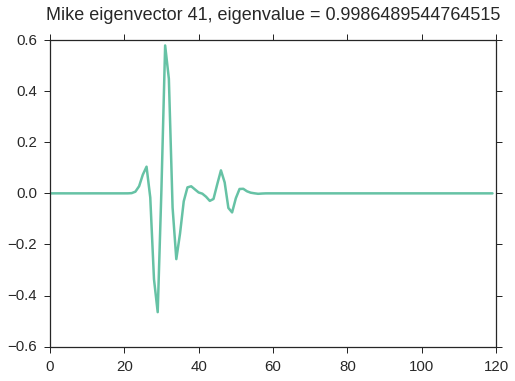

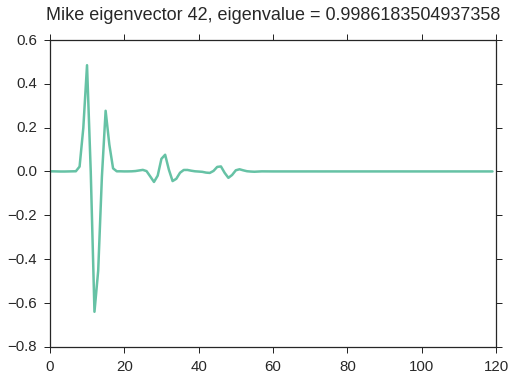

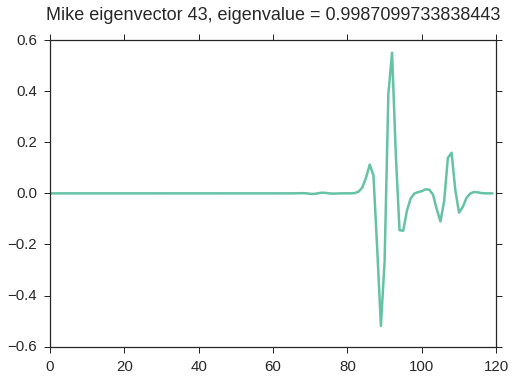

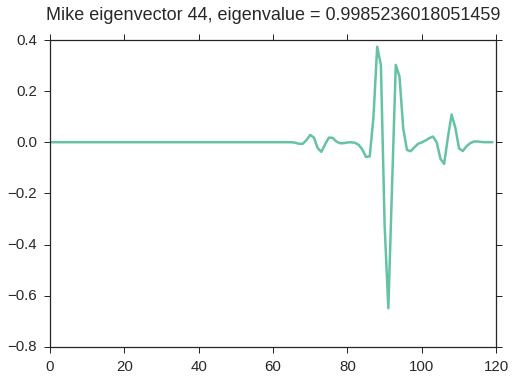

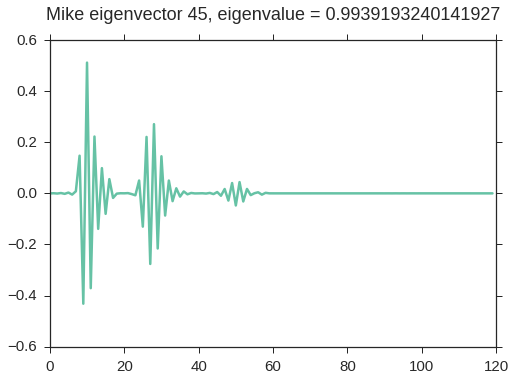

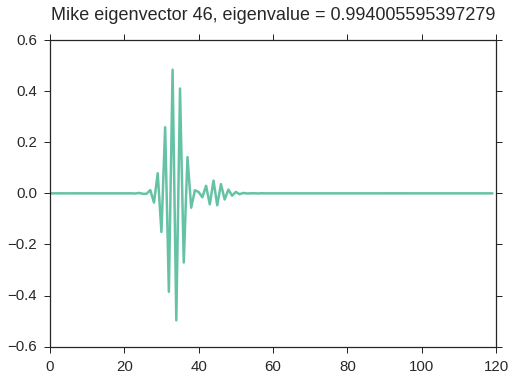

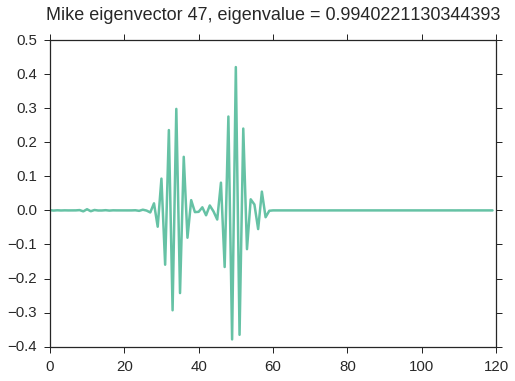

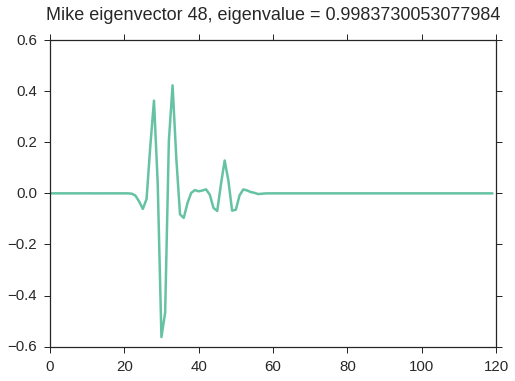

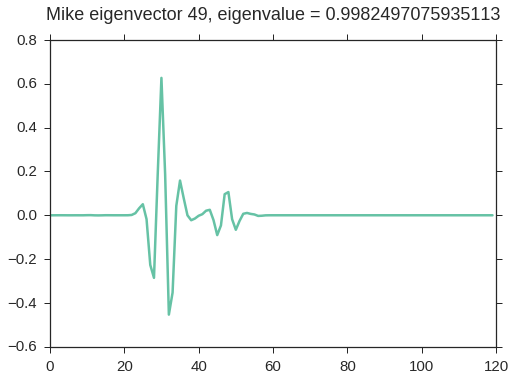

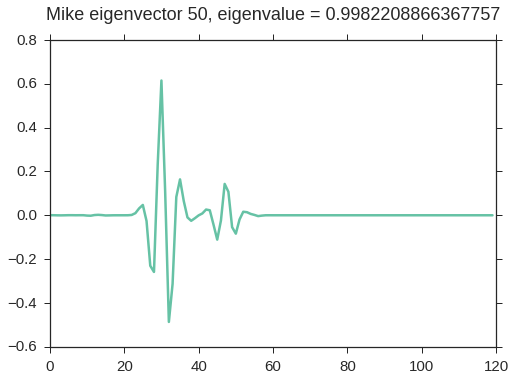

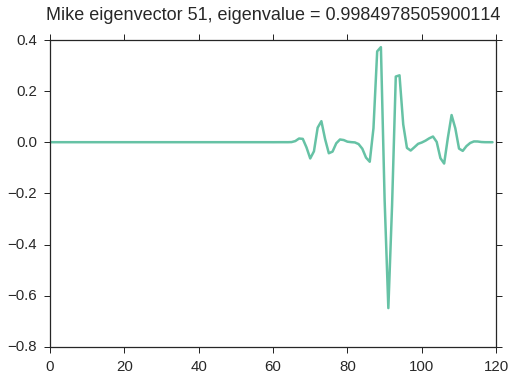

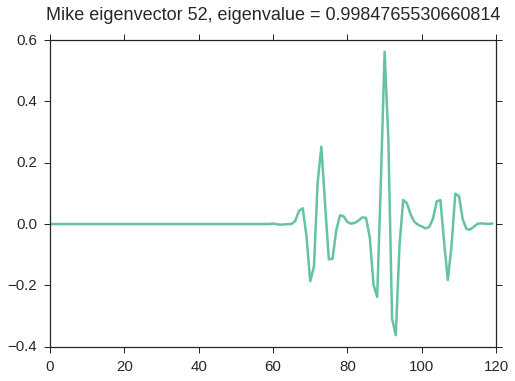

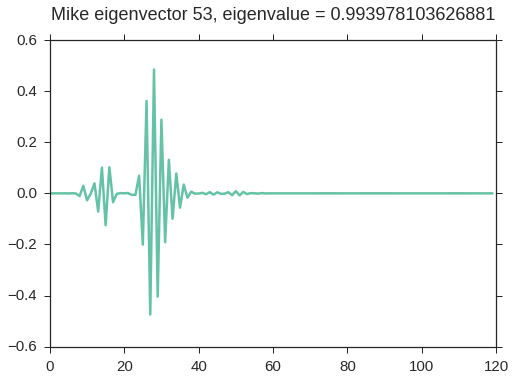

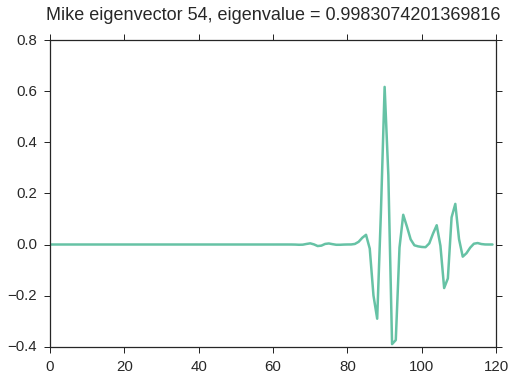

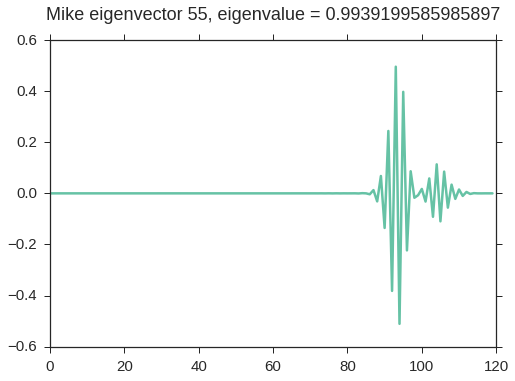

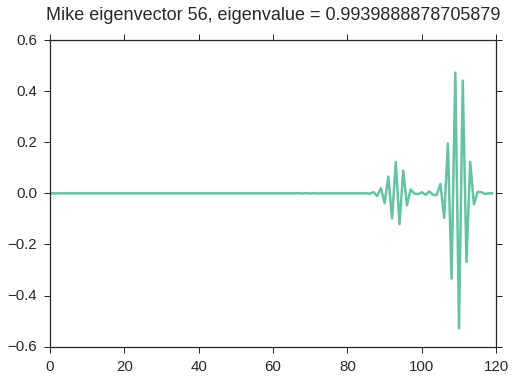

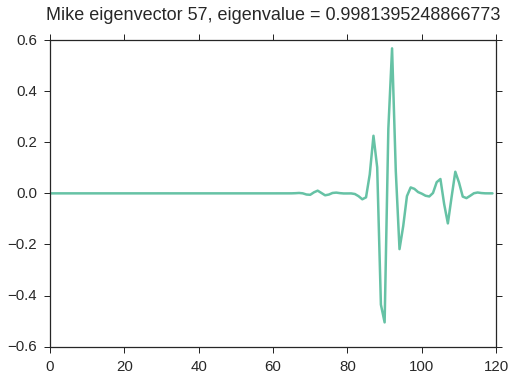

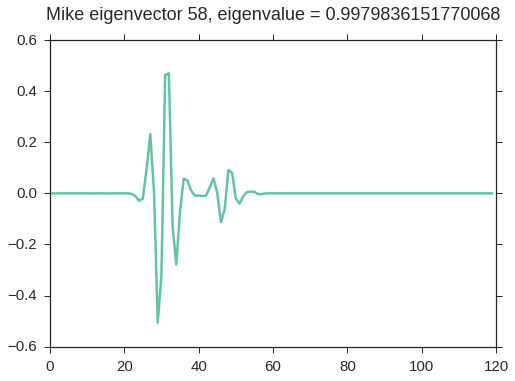

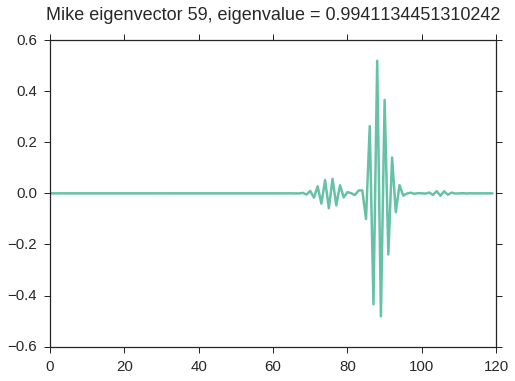

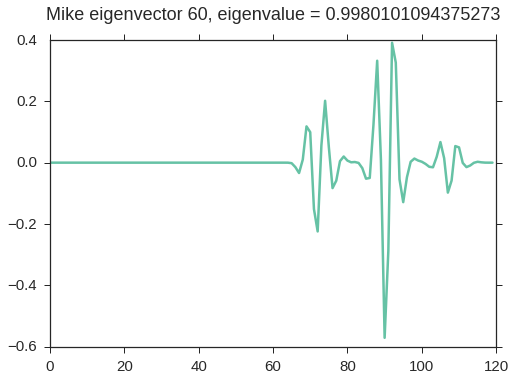

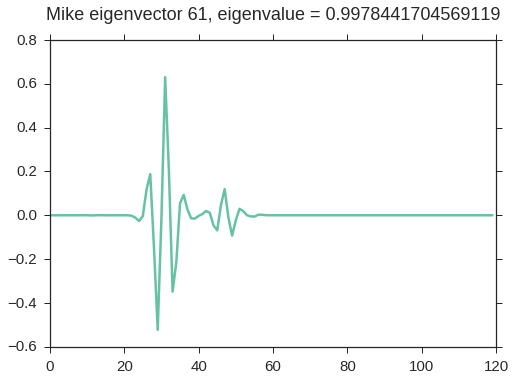

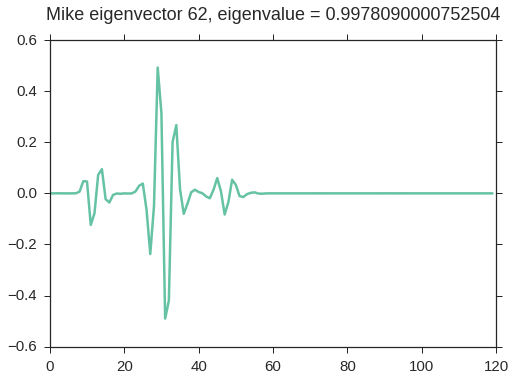

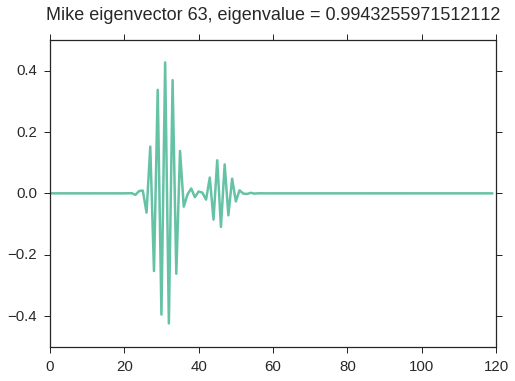

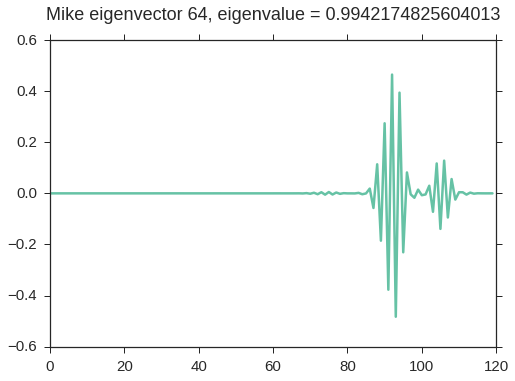

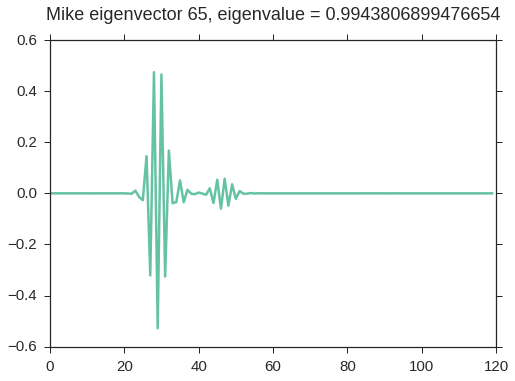

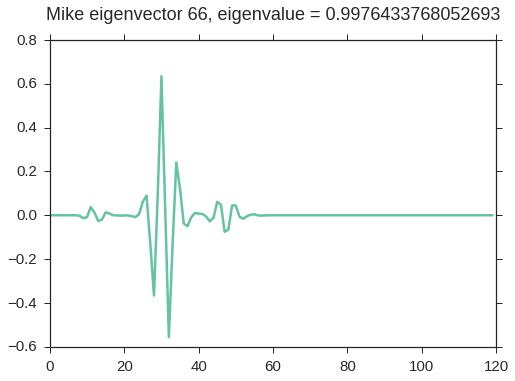

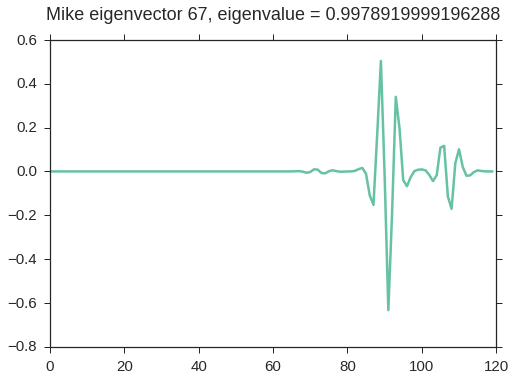

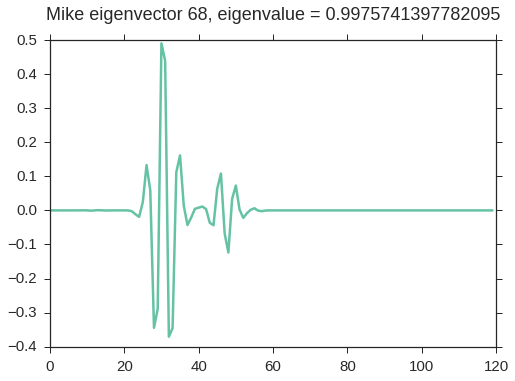

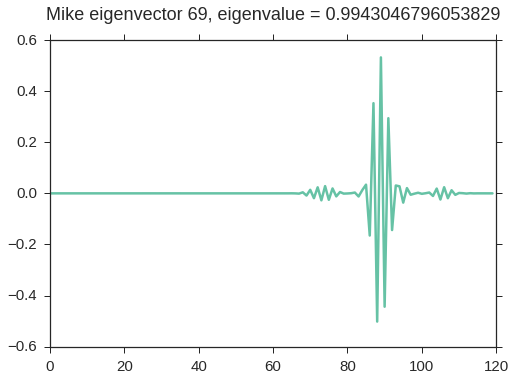

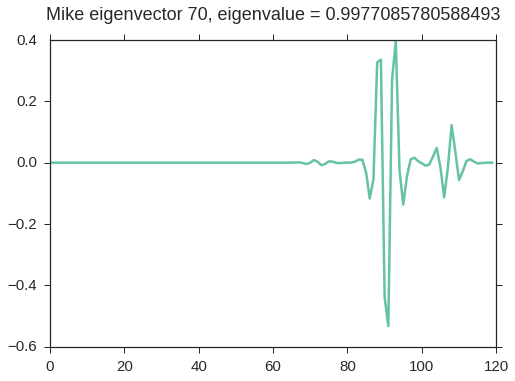

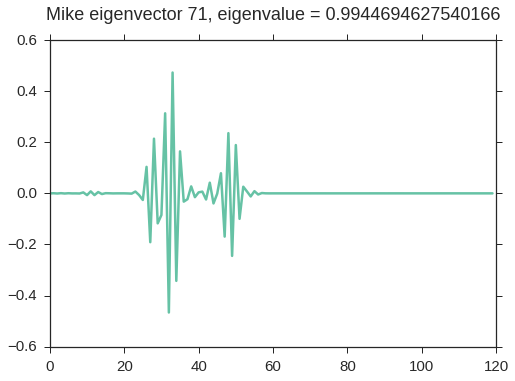

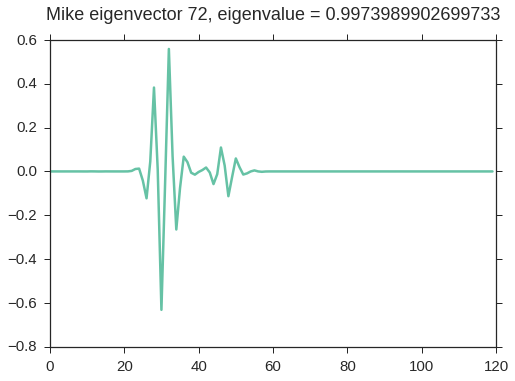

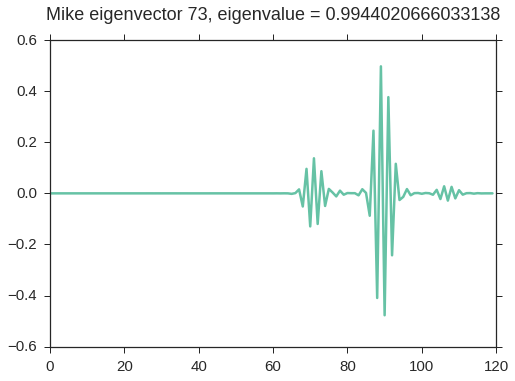

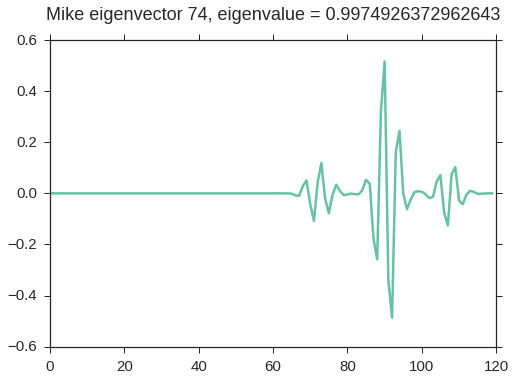

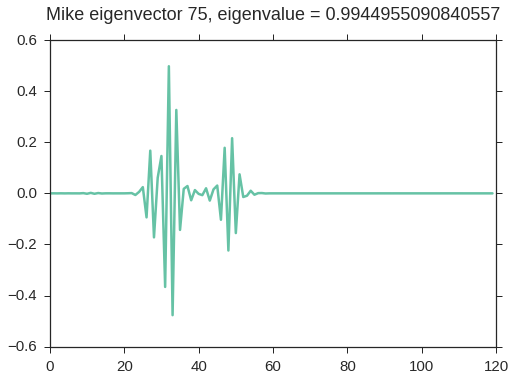

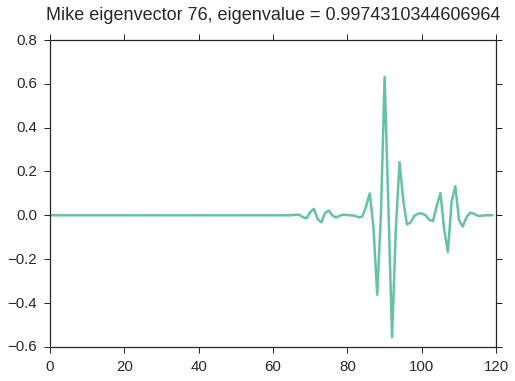

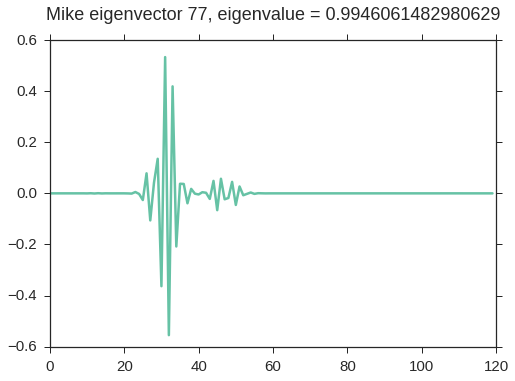

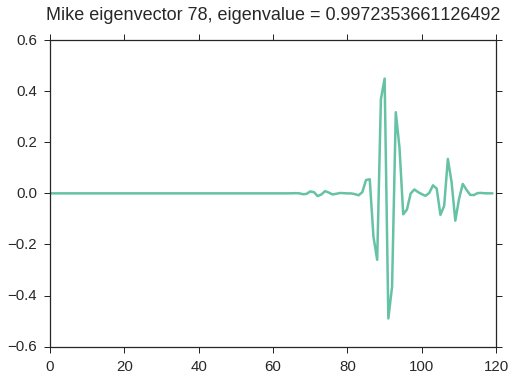

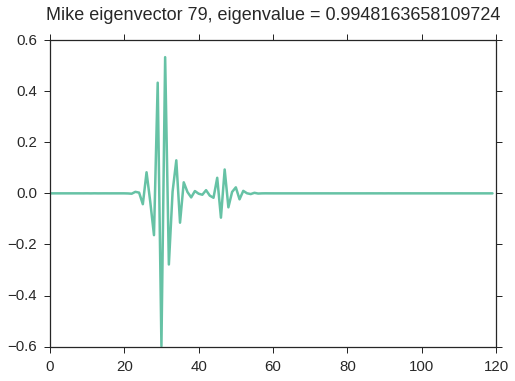

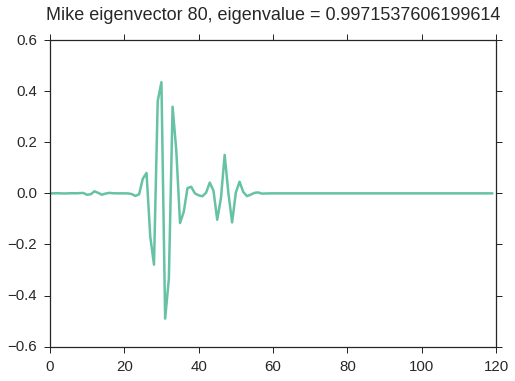

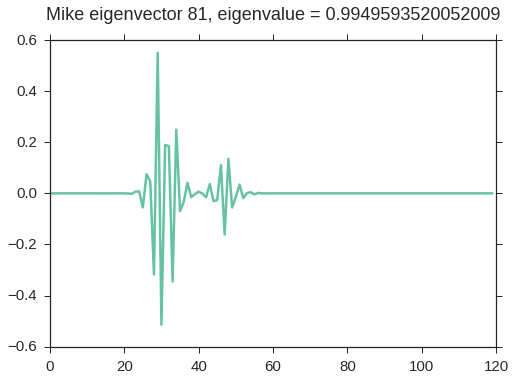

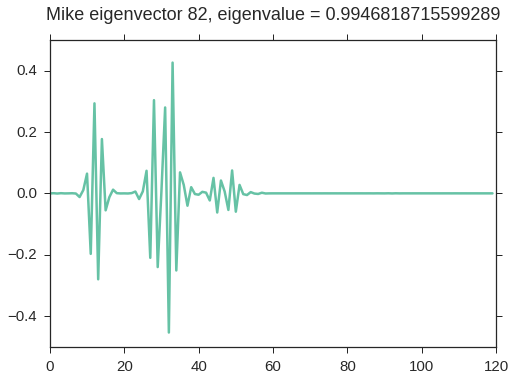

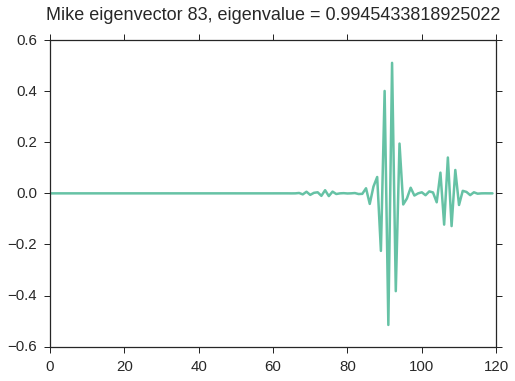

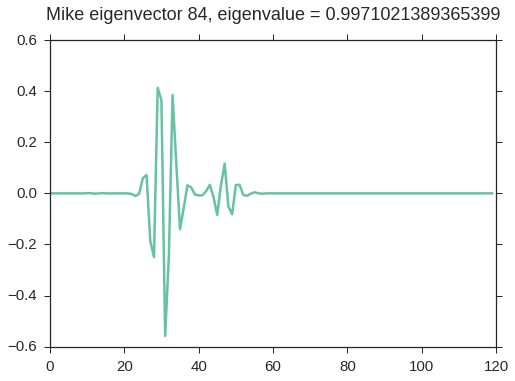

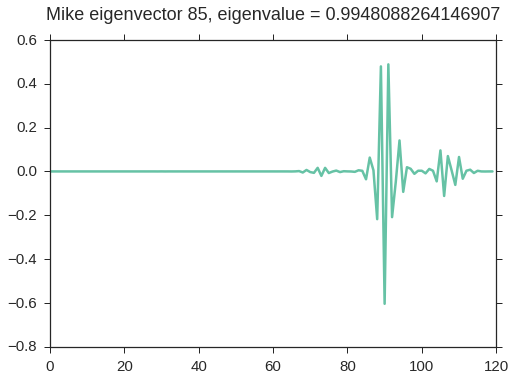

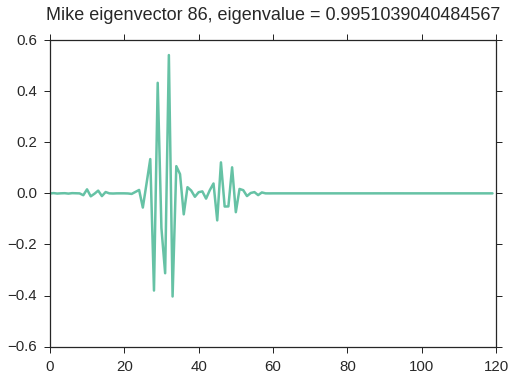

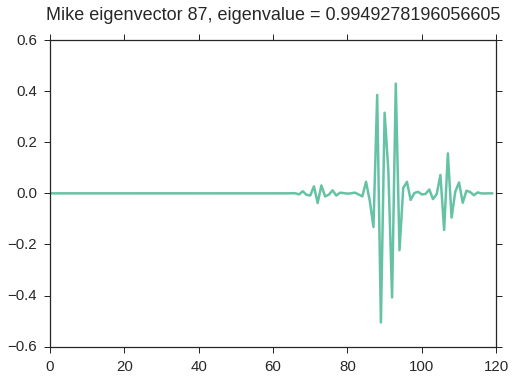

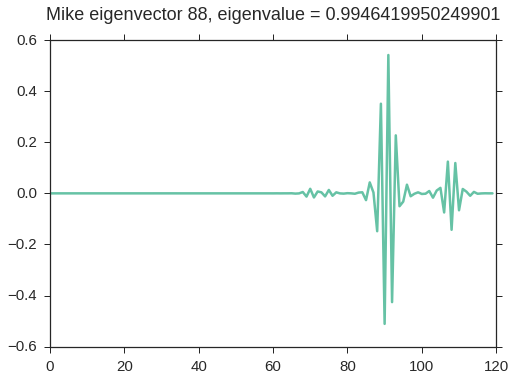

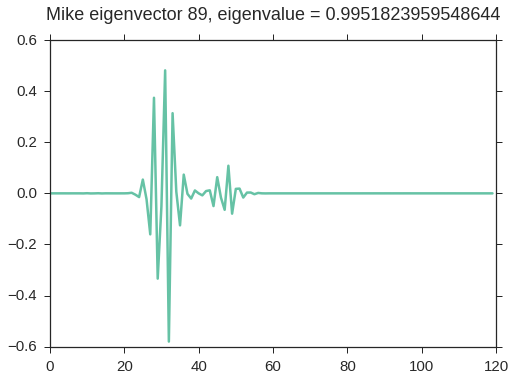

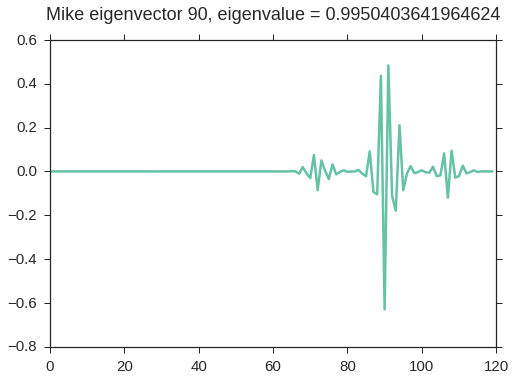

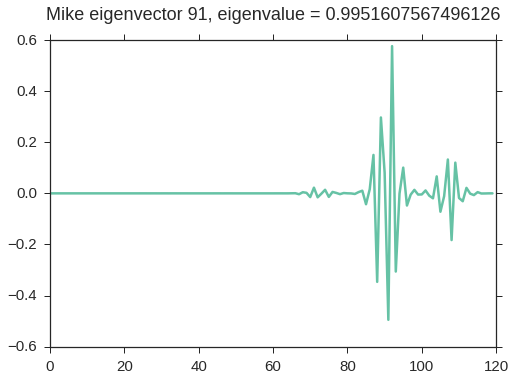

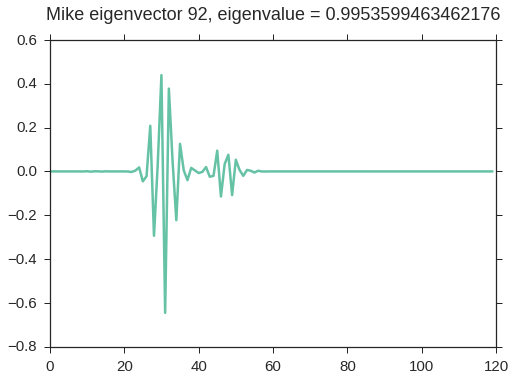

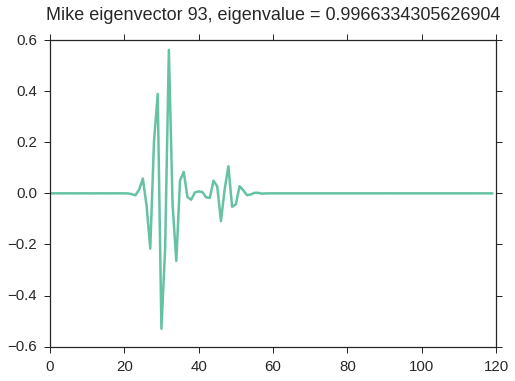

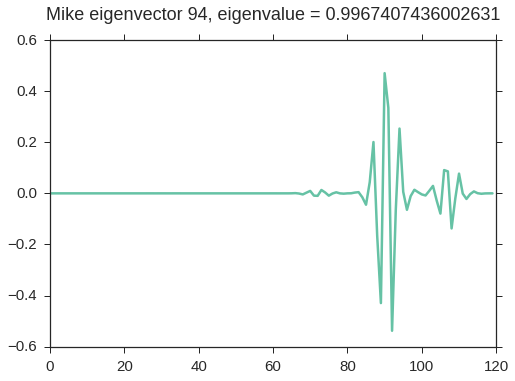

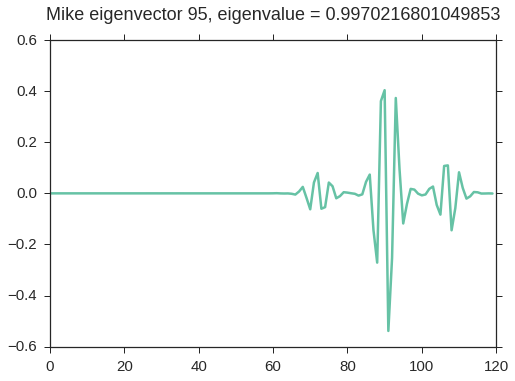

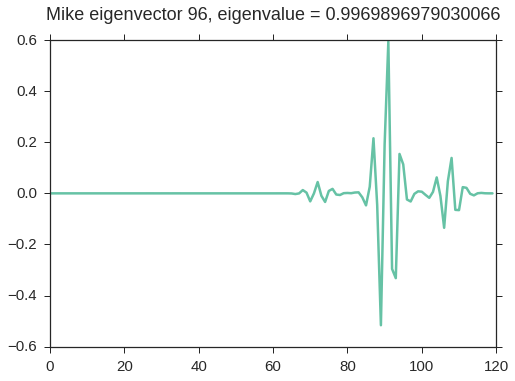

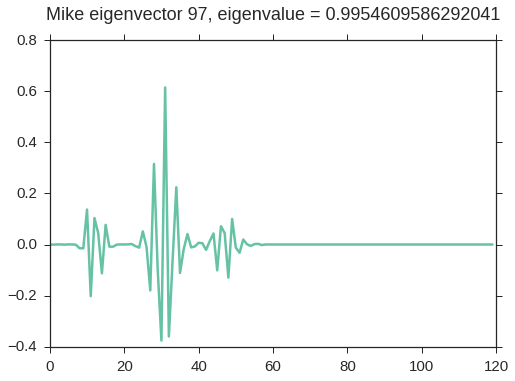

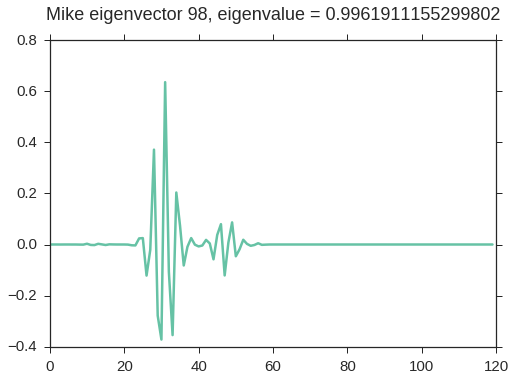

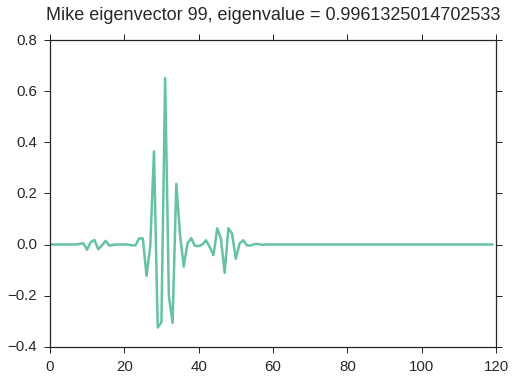

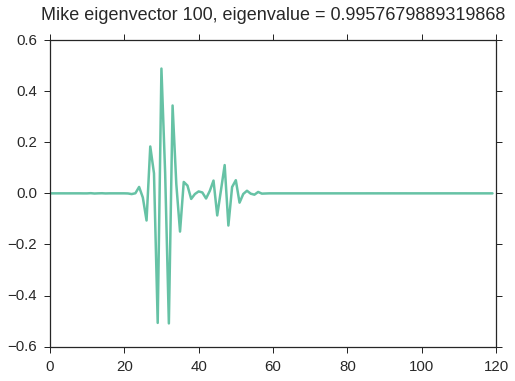

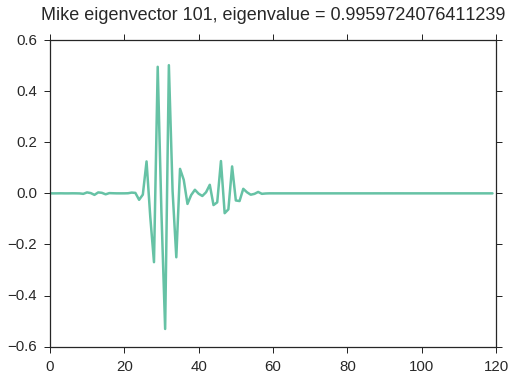

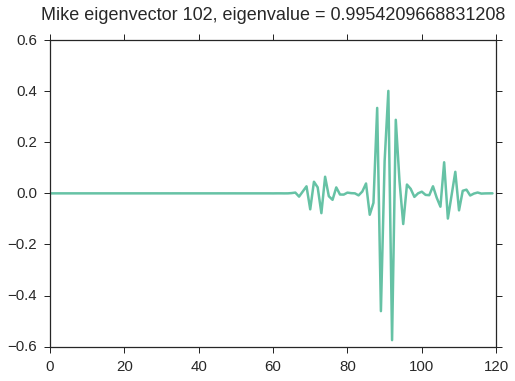

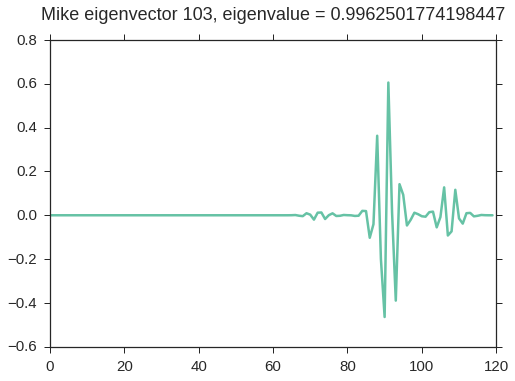

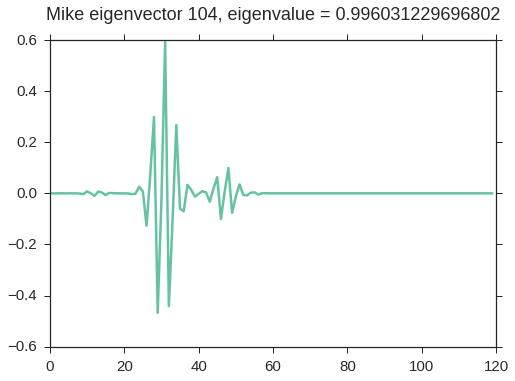

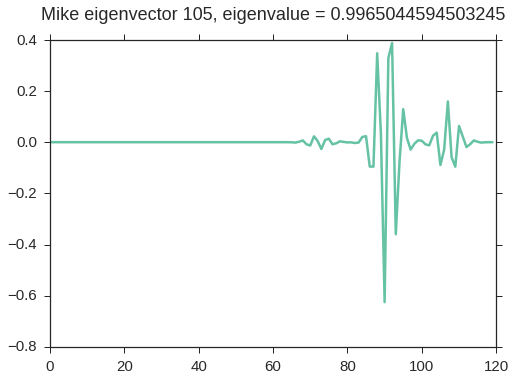

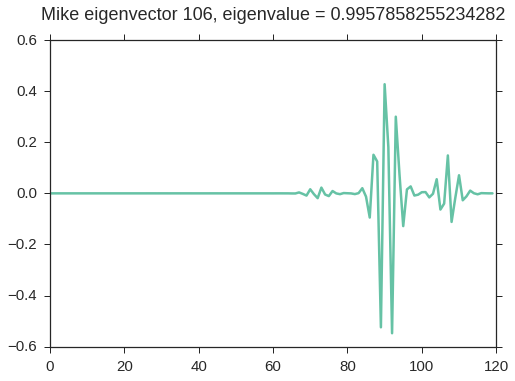

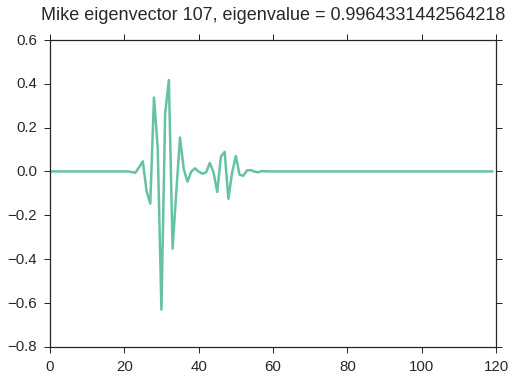

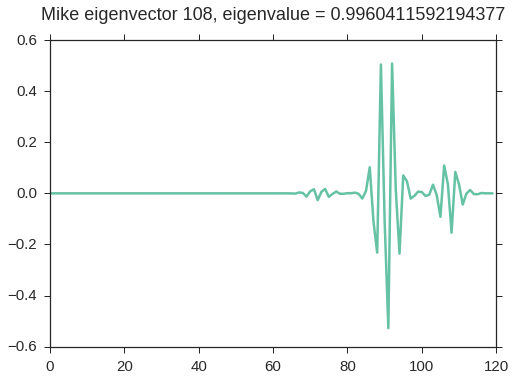

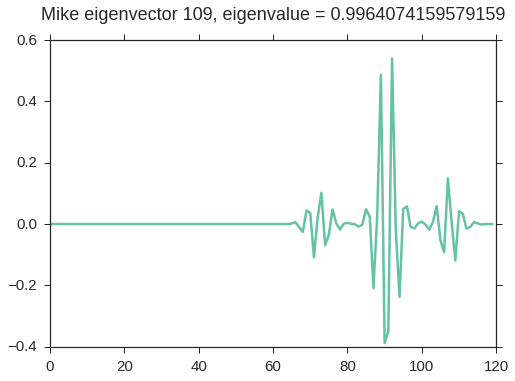

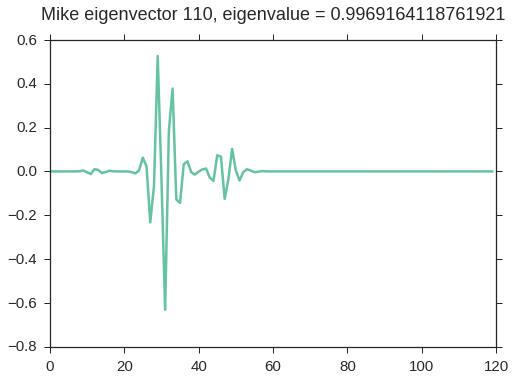

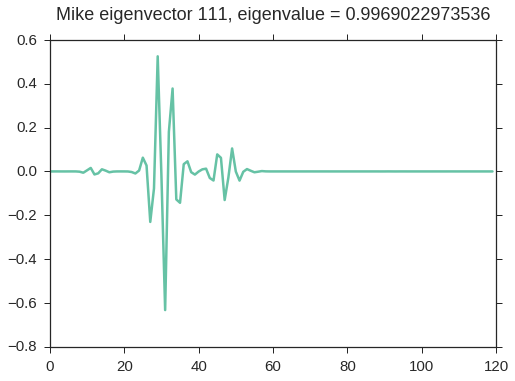

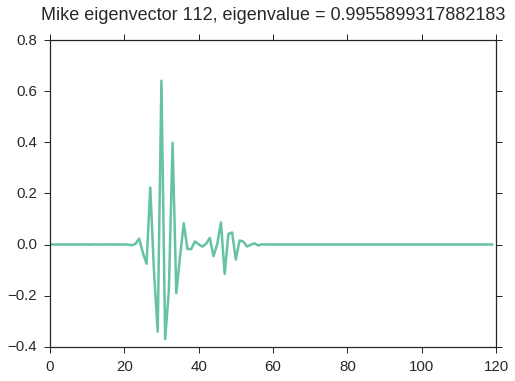

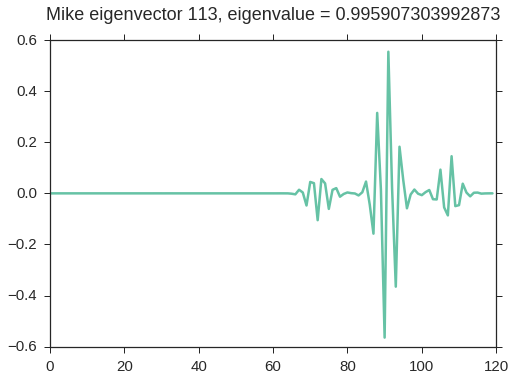

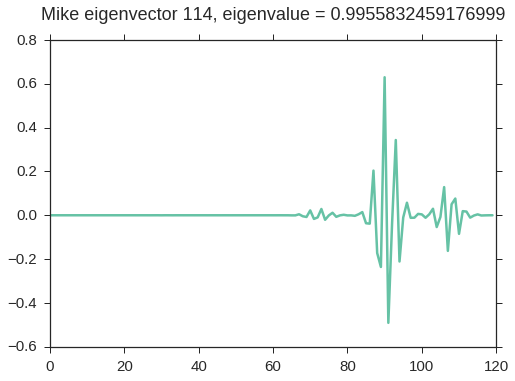

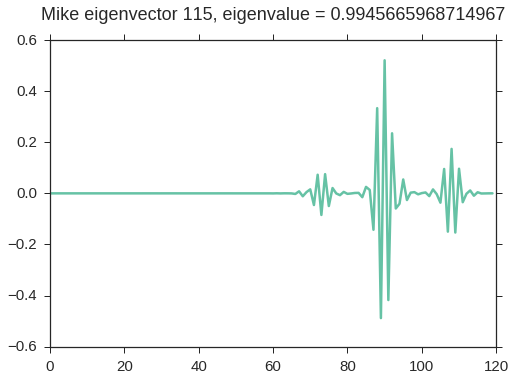

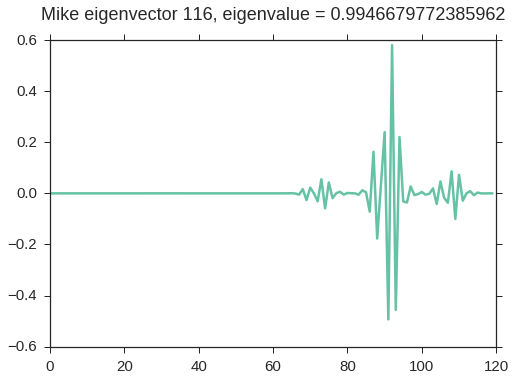

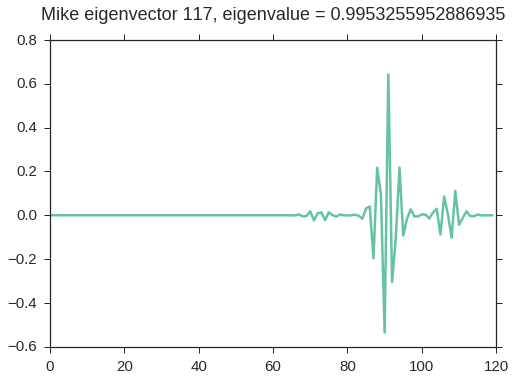

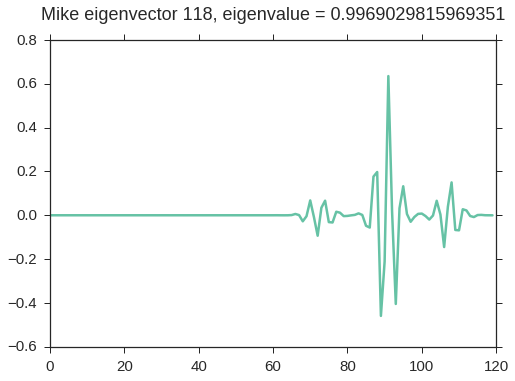

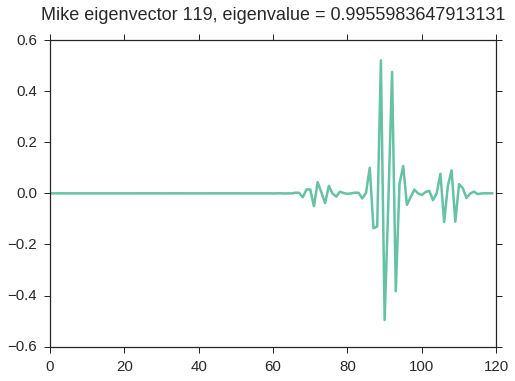

In [199]:
for i in range(2*bins):
    plt.figure()
    plt.plot(range(2*bins), mike_eigenvectors[:, i].astype(float))
    plt.title('Mike eigenvector {}, eigenvalue = {}'.format(i, mike_eigenvalues[i]), y=1.05)
    plt.show()

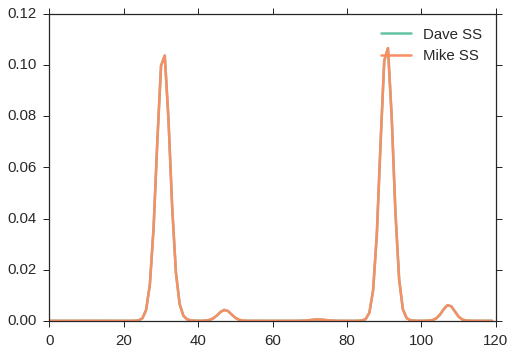

In [29]:
plt.figure()
plt.plot(range(2 * bins), ss, label='Dave SS')
plt.plot(range(2 * bins), mike_ss, label='Mike SS')
plt.legend()
plt.show()

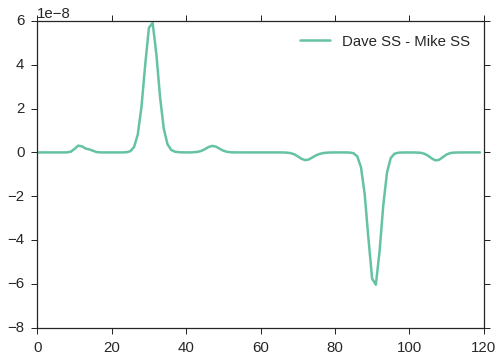

In [220]:
plt.figure()
plt.plot(range(2 * bins), ss - mike_ss, label='Dave SS - Mike SS')
plt.legend()
plt.show()

In [31]:
# Flux across boundaries
flux_u = np.empty((bins))
for i in range(bins):
        if i == 0:
            flux_u[i] = (
                        - mike_ss[i]           * transition_matrix[i][i + 1]/dt +
                        + mike_ss[i + 1]       * transition_matrix[i + 1][i]/dt
                        )
        if i == bins - 1:
            flux_u[i] = (
                        - mike_ss[i]        * transition_matrix[i][0]/dt +
                        + mike_ss[0]        * transition_matrix[0][i]/dt
                        )

        else:
            flux_u[i] = (
                        - mike_ss[i]        * transition_matrix[i][i + 1]/dt +
                        + mike_ss[i + 1]    * transition_matrix[i + 1][i]/dt
                        )
flux_b = np.empty((bins))
for i in range(bins, 2 * bins):
        if i == bins:
            flux_b[i - bins] = (
                               - mike_ss[i]            * transition_matrix[i][i + 1]/dt +
                               + mike_ss[i + 1]        * transition_matrix[i + 1][i]/dt
                               )
        if i == 2 * bins - 1:
            flux_b[i - bins] = (
                               - mike_ss[i]        * transition_matrix[i][bins]/dt +
                               + mike_ss[bins]     * transition_matrix[bins][i]/dt
                               )

        else:
            flux_b[i - bins] = (
                               - mike_ss[i]        * transition_matrix[i][i + 1]/dt +
                               + mike_ss[i + 1]    * transition_matrix[i + 1][i]/dt
                               )
flux_ub = np.empty((bins))
for i in range(bins):
            flux_ub[i] = (
                         - mike_ss[i]            * transition_matrix[i][i + bins]/dt +
                         + mike_ss[i + bins]     * transition_matrix[i + bins][i]/dt
                         )
print('Flux from `i` to `i + 1` on unbound surface:')
print(flux_u)
print('Flux from `i` to `i + 1` on bound surface:')
print(flux_b)
print('Flux from `i` on unbound surface to bound surface:')
print(flux_ub)

Flux from `i` to `i + 1` on unbound surface:
[ -2.42715784e-05  -2.49476445e-05  -1.26456013e-05  -9.41268917e-07
   1.30878571e-05   2.34540582e-05   2.49760188e-05   2.57928154e-05
   2.75147470e-05   3.09935878e-05   3.41591081e-05   3.09086845e-05
   2.85042770e-05   2.55279260e-05   2.65970590e-05   2.24408685e-05
   2.55838529e-05   1.54664682e-05   1.78027083e-05   1.57532567e-05
   1.36802062e-05   1.41597422e-05   1.13244391e-05   1.12832786e-05
   9.14402335e-06   7.41667463e-06   7.81263225e-06  -2.22120434e-06
  -7.59214163e-06  -2.79378146e-05  -5.26327640e-05  -7.77505338e-05
  -9.28128138e-05  -9.61069018e-05  -9.82955098e-05  -9.85641964e-05
  -1.03199694e-04  -1.00112004e-04  -1.04606777e-04  -9.86339537e-05
  -1.03067431e-04  -9.67500373e-05  -9.55635551e-05  -8.50532233e-05
  -7.74303917e-05  -6.25923276e-05  -5.49931428e-05  -5.33987186e-05
  -4.76824353e-05  -4.56673151e-05  -3.89632332e-05  -3.38277896e-05
  -3.32244135e-05  -3.30169853e-05  -3.19573969e-05  -3.10

In [ ]:
# Flux across boundaries
flux_u = np.empty((bins))
for i in range(bins):
        if i == 0:
            flux_u[i] = (
                        - mike_ss[i]           * transition_matrix[i][i + 1]/dt +
                        + mike_ss[i + 1]       * transition_matrix[i + 1][i]/dt
                        )
        if i == bins - 1:
            flux_u[i] = (
                        - mike_ss[i]        * transition_matrix[i][0]/dt +
                        + mike_ss[0]        * transition_matrix[0][i]/dt
                        )

        else:
            flux_u[i] = (
                        - mike_ss[i]        * transition_matrix[i][i + 1]/dt +
                        + mike_ss[i + 1]    * transition_matrix[i + 1][i]/dt
                        )
flux_b = np.empty((bins))
for i in range(bins, 2 * bins):
        if i == bins:
            flux_b[i - bins] = (
                               - mike_ss[i]            * transition_matrix[i][i + 1]/dt +
                               + mike_ss[i + 1]        * transition_matrix[i + 1][i]/dt
                               )
        if i == 2 * bins - 1:
            flux_b[i - bins] = (
                               - mike_ss[i]        * transition_matrix[i][bins]/dt +
                               + mike_ss[bins]     * transition_matrix[bins][i]/dt
                               )

        else:
            flux_b[i - bins] = (
                               - mike_ss[i]        * transition_matrix[i][i + 1]/dt +
                               + mike_ss[i + 1]    * transition_matrix[i + 1][i]/dt
                               )
flux_ub = np.empty((bins))
for i in range(bins):
            flux_ub[i] = (
                         - mike_ss[i]            * transition_matrix[i][i + bins]/dt +
                         + mike_ss[i + bins]     * transition_matrix[i + bins][i]/dt
                         )
print('Flux from `i` to `i + 1` on unbound surface:')
print(flux_u)
print('Flux from `i` to `i + 1` on bound surface:')
print(flux_b)
print('Flux from `i` on unbound surface to bound surface:')
print(flux_ub)

In [229]:
np.savetxt('chi1-eigenvector.mtx', mike_ss, fmt='%.24e')

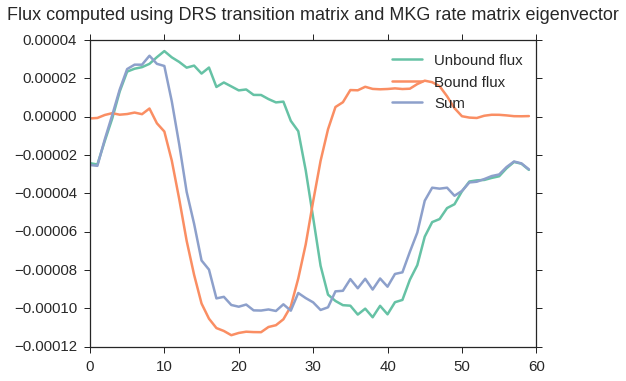

In [33]:
plt.figure()
plt.plot(range(bins), flux_u, label='Unbound flux')
plt.plot(range(bins), flux_b, label='Bound flux')
plt.plot(range(bins), flux_u + flux_b, label='Sum')
plt.title('Flux computed using DRS transition matrix and MKG rate matrix eigenvector', y=1.05)
plt.legend()
plt.show()

In [36]:
# Flux across boundaries
flux_u = np.empty((bins))
for i in range(bins):
        if i == 0:
            flux_u[i] = (
                        - mike_ss[i]           * mike_matrix[i][i + 1] +
                        + mike_ss[i + 1]       * mike_matrix[i + 1][i]
                        )
        if i == bins - 1:
            flux_u[i] = (
                        - mike_ss[i]        * mike_matrix[i][0] +
                        + mike_ss[0]        * mike_matrix[0][i]
                        )

        else:
            flux_u[i] = (
                        - mike_ss[i]        * mike_matrix[i][i + 1] +
                        + mike_ss[i + 1]    * mike_matrix[i + 1][i]
                        )
flux_b = np.empty((bins))
for i in range(bins, 2 * bins):
        if i == bins:
            flux_b[i - bins] = (
                               - mike_ss[i]            * mike_matrix[i][i + 1] +
                               + mike_ss[i + 1]        * mike_matrix[i + 1][i]
                               )
        if i == 2 * bins - 1:
            flux_b[i - bins] = (
                               - mike_ss[i]        * mike_matrix[i][bins] +
                               + mike_ss[bins]     * mike_matrix[bins][i]
                               )

        else:
            flux_b[i - bins] = (
                               - mike_ss[i]        * mike_matrix[i][i + 1] +
                               + mike_ss[i + 1]    * mike_matrix[i + 1][i]
                               )
flux_ub = np.empty((bins))
for i in range(bins):
            flux_ub[i] = (
                         - mike_ss[i]            * mike_matrix[i][i + bins] +
                         + mike_ss[i + bins]     * mike_matrix[i + bins][i]
                         )
print('Flux from `i` to `i + 1` on unbound surface:')
print(flux_u)
print('Flux from `i` to `i + 1` on bound surface:')
print(flux_b)
print('Flux from `i` on unbound surface to bound surface:')
print(flux_ub)

Flux from `i` to `i + 1` on unbound surface:
[ -3.49909501e-16  -3.59655961e-16  -1.82304421e-16  -1.35697371e-17
   1.88680170e-16   3.38123779e-16   7.40695735e-12   1.35981851e-09
   1.03002936e-08   2.93720672e-08   2.78797429e-08  -5.61302316e-09
  -1.84759802e-08  -6.84235624e-09  -1.17815722e-08  -1.30773720e-08
  -4.90177658e-09  -6.64779439e-10   2.56651490e-16   2.27105716e-16
   1.16502569e-09   1.52935996e-08   1.24109191e-07   6.94052869e-07
   3.21264156e-06   1.21470346e-05   3.42275285e-05   7.11712117e-05
   1.02476743e-04   8.65405460e-05   1.13128067e-05  -7.28257477e-05
  -1.03965114e-04  -7.95141200e-05  -4.06201900e-05  -1.53540544e-05
  -4.89879460e-06  -1.40349024e-06  -3.96327487e-07  -1.26998515e-07
   2.90952541e-08   2.64879660e-07   8.05166003e-07   1.93534571e-06
   3.52864554e-06   4.21662057e-06   2.28787537e-06  -1.35078522e-06
  -4.03618920e-06  -4.05576821e-06  -2.41770803e-06  -9.70543527e-07
  -3.03970301e-07  -6.18320712e-08  -1.85986825e-09  -9.24

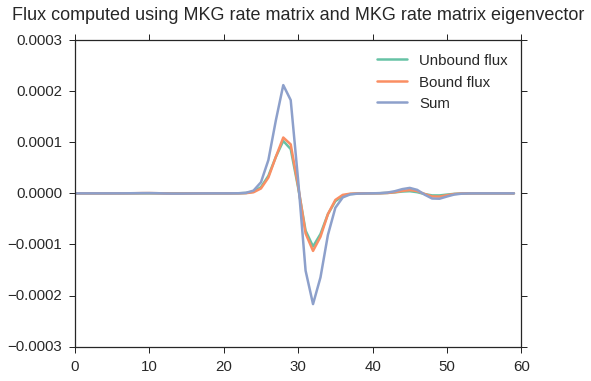

In [37]:
plt.figure()
plt.plot(range(bins), flux_u, label='Unbound flux')
plt.plot(range(bins), flux_b, label='Bound flux')
plt.plot(range(bins), flux_u + flux_b, label='Sum')
plt.title('Flux computed using MKG rate matrix and MKG rate matrix eigenvector', y=1.05)
plt.legend()
plt.show()

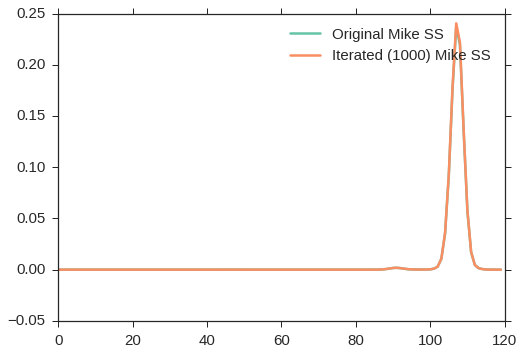

In [194]:
# new_mike_ss = np.mat(mike_ss)
for i in range(1000):
    # new_mike_ss = np.dot(new_mike_ss, mike_matrix)
    # new_mike_ss = mike_matrix * new_mike_ss
    if i == 0:
        new_mike_ss = np.mat(mike_matrix) * np.mat(mike_ss).T
    else:
        new_mike_ss = np.mat(mike_matrix) * np.mat(new_mike_ss)
    # new_mike_ss /= np.sum(new_mike_ss)
plt.figure()
plt.plot(range(2 * bins), mike_ss, label='Original Mike SS')
plt.plot(range(2 * bins), new_mike_ss, label='Iterated (1000) Mike SS')
plt.legend()
plt.show()

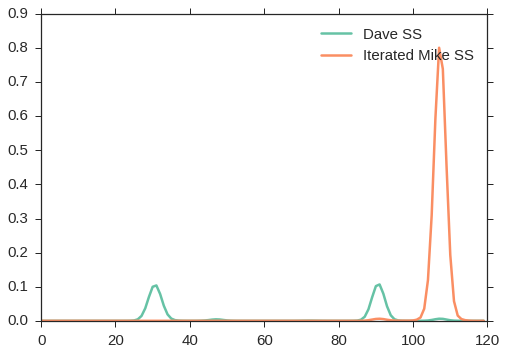

In [187]:
plt.figure()
plt.plot(range(2 * bins), ss, label='Dave SS')
plt.plot(range(2 * bins), new_mike_ss, label='Iterated Mike SS')
plt.legend()
plt.show()

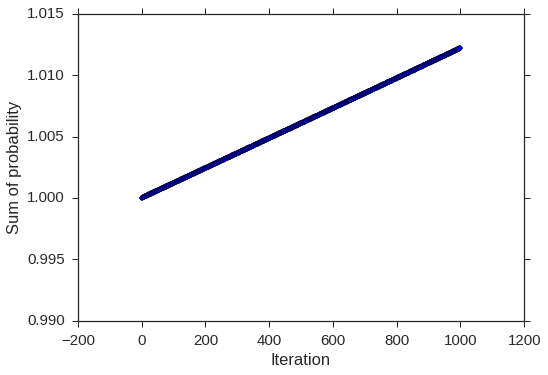

In [193]:
new_mike_ss = mike_ss
plt.figure()
for i in range(1000):
    # new_mike_ss = np.dot( mike_matrix, new_mike_ss)
    # new_mike_ss /= np.sum(new_mike_ss)
    if i == 0:
        new_mike_ss = np.mat(mike_matrix) * np.mat(mike_ss).T
    else:
        new_mike_ss = np.mat(mike_matrix) * np.mat(new_mike_ss)
    plt.scatter(i, np.sum(new_mike_ss))
plt.ylabel('Sum of probability')
plt.xlabel('Iteration')
plt.show()

In [165]:
new_mike_ss

array([  5.40258984e-12,   4.44751753e-12,   3.45183729e-12,
         2.50170637e-12,   1.66324194e-12,   9.28864868e-13,
         3.80656081e-13,   7.51675646e-14,   2.34937772e-13,
         1.66086370e-12,   7.27542940e-12,   1.40015254e-11,
         1.25711493e-11,   8.18385405e-12,   6.67906060e-12,
         3.80355971e-12,   8.79191982e-13,   8.34668422e-14,
         5.18028785e-15,  -3.83521710e-15,  -2.37424254e-15,
         3.37493055e-13,   7.17835793e-12,   7.94682752e-11,
         5.67961066e-10,   3.08146009e-09,   1.32711878e-08,
         4.38811937e-08,   1.12342185e-07,   2.16827757e-07,
         3.17227459e-07,   3.43235118e-07,   2.79170650e-07,
         1.68179822e-07,   8.48589550e-08,   4.28160588e-08,
         2.50314142e-08,   1.90125132e-08,   1.77015906e-08,
         1.81924404e-08,   1.80114231e-08,   5.86658822e-08,
         2.75136549e-07,   9.75123351e-07,   2.75902189e-06,
         6.12005686e-06,   1.00538620e-05,   1.19826022e-05,
         1.05733536e-05,

In [162]:
np.mat(mike_matrix) * np.mat(mike_ss).T

matrix([[  5.40256954e-12],
        [  4.44742594e-12],
        [  3.45187116e-12],
        [  2.50183654e-12],
        [  1.66336689e-12],
        [  9.29118922e-13],
        [  3.80740123e-13],
        [  7.52961571e-14],
        [  2.35003751e-13],
        [  1.66090467e-12],
        [  7.27560653e-12],
        [  1.40018223e-11],
        [  1.25713269e-11],
        [  8.18391419e-12],
        [  6.67904064e-12],
        [  3.80346655e-12],
        [  8.79120209e-13],
        [  8.34331539e-14],
        [  5.14574583e-15],
        [ -3.81982231e-15],
        [ -2.28238416e-15],
        [  3.37508928e-13],
        [  7.17844426e-12],
        [  7.94692690e-11],
        [  5.67967932e-10],
        [  3.08149752e-09],
        [  1.32713487e-08],
        [  4.38817261e-08],
        [  1.12343549e-07],
        [  2.16830389e-07],
        [  3.17231310e-07],
        [  3.43239285e-07],
        [  2.79174039e-07],
        [  1.68181863e-07],
        [  8.48599850e-08],
        [  4.2816578

In [180]:
new_mike_ss = np.mat(mike_ss)
print(new_mike_ss)
new_mike_ss = np.mat(mike_matrix) * np.mat(new_mike_ss).T
print(new_mike_ss)

[[  5.40258984e-12   4.44751753e-12   3.45183729e-12   2.50170637e-12
    1.66324194e-12   9.28864868e-13   3.80656081e-13   7.51675646e-14
    2.34937772e-13   1.66086370e-12   7.27542940e-12   1.40015254e-11
    1.25711493e-11   8.18385405e-12   6.67906060e-12   3.80355971e-12
    8.79191982e-13   8.34668422e-14   5.18028785e-15  -3.83521710e-15
   -2.37424254e-15   3.37493055e-13   7.17835793e-12   7.94682752e-11
    5.67961066e-10   3.08146009e-09   1.32711878e-08   4.38811937e-08
    1.12342185e-07   2.16827757e-07   3.17227459e-07   3.43235118e-07
    2.79170650e-07   1.68179822e-07   8.48589550e-08   4.28160588e-08
    2.50314142e-08   1.90125132e-08   1.77015906e-08   1.81924404e-08
    1.80114231e-08   5.86658822e-08   2.75136549e-07   9.75123351e-07
    2.75902189e-06   6.12005686e-06   1.00538620e-05   1.19826022e-05
    1.05733536e-05   6.72676714e-06   3.09479688e-06   1.08736440e-06
    3.11249955e-07   7.58878121e-08   2.31655691e-08   2.10307841e-08
    1.20055099e-08  

# Investigate Gaussian smoothing

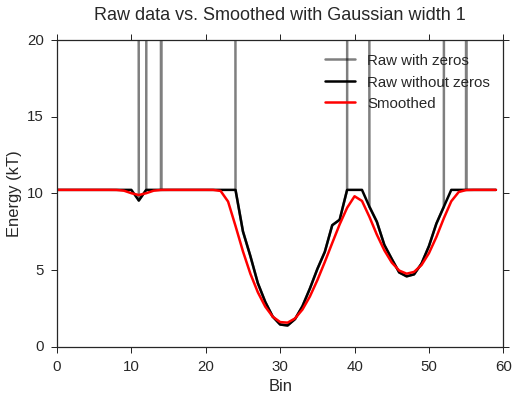

In [69]:

unbound_files=['/home/dslochower/Dropbox/DavidS/ProteinKinaseATorsions/apo/chi1ARG130_chi_pop_hist_targ.txt']
bound_files=['/home/dslochower/Dropbox/DavidS/ProteinKinaseATorsions/atpmg/chi1ARG130_chi_pop_hist_ref.txt']

# Read in population data and convert to energy surfaces
unbound = genfromtxt(unbound_files[0], delimiter=',', skip_header=1)
bound = genfromtxt(bound_files[0], delimiter=',', skip_header=1)

unbound_energy = -kT * np.log(unbound)
bound_energy = -kT * np.log(bound)

unbound_data_nonzero = np.empty((bins))
for i in range(bins):
    if unbound[i] == 0:
        unbound_data_nonzero[i] = min(unbound[np.nonzero(unbound)])
    else:
        unbound_data_nonzero[i] = unbound[i]
unbound_nonzero = -kT * np.log(unbound_data_nonzero)
tmp = np.empty((bins))

# for i in range(bins):
#     if bound[i] == 0:
#         tmp[i] = min(bound[np.nonzero(bound)])
#     else:
#         tmp[i] = bound[i]
# bound_nonzero = -kT * np.log(tmp)

bins = len(unbound)
kT = 1

from scipy.ndimage.filters import gaussian_filter
unbound_smooth   = gaussian_filter(unbound_data_nonzero, 1)
unbound_smooth_e = -kT * np.log(unbound_smooth)
# bound_smooth   = gaussian_filter(bound_nonzero, 1)
# bound_smooth_e = -kT * np.log(bound_smooth)
plt.figure()
plt.plot(range(bins), [unbound_energy[i] if np.isfinite(unbound_energy[i]) else 999 for i in range(bins)], c='k', alpha = 0.5, label='Raw with zeros')
plt.plot(range(bins), unbound_nonzero, c='k', label='Raw without zeros')
plt.plot(range(bins), unbound_smooth_e, c='r', label='Smoothed')
plt.legend()
plt.xlabel('Bin')
plt.ylabel('Energy (kT)')
plt.ylim([0, 20])
plt.title('Raw data vs. Smoothed with Gaussian width 1', y=1.05)
plt.show()

In [67]:
unbound_smooth

array([ 10.22644024,  10.22644024,  10.22644024,  10.22644024,
        10.22644024,  10.22644024,  10.22644024,  10.22634747,
        10.22336831,  10.18901644,  10.05871841,   9.9499137 ,
        10.05871841,  10.18901644,  10.22336831,  10.22634747,
        10.22644024,  10.22644024,  10.22644024,  10.22644024,
        10.22644024,  10.22607782,  10.21386072,  10.06028198,
         9.31016107,   7.73989157,   5.94666071,   4.35894087,
         3.08563783,   2.1786364 ,   1.67891577,   1.6236707 ,
         2.01455839,   2.79802142,   3.85754112,   5.05448458,
         6.32125145,   7.55064294,   8.65081205,   9.60751051,
        10.04162184,   9.82292001,   9.07058939,   7.99637169,
         6.8293364 ,   5.81596903,   5.10602052,   4.80954844,
         4.98565658,   5.63912373,   6.68853775,   7.91303424,
         9.03666307,   9.82509748,  10.15689683,  10.22127729,
        10.22629321,  10.22644024,  10.22644024,  10.22644024])

In [68]:
unbound_nonzero

array([ 10.22644024,  10.22644024,  10.22644024,  10.22644024,
        10.22644024,  10.22644024,  10.22644024,  10.22644024,
        10.22644024,  10.22644024,  10.22644024,   9.53329306,
        10.22644024,  10.22644024,  10.22644024,  10.22644024,
        10.22644024,  10.22644024,  10.22644024,  10.22644024,
        10.22644024,  10.22644024,  10.22644024,  10.22644024,
        10.22644024,   7.51839004,   5.90895213,   4.15109421,
         2.9246179 ,   1.96646458,   1.45367503,   1.38963036,
         1.80685988,   2.65085559,   3.79995178,   5.06738494,
         6.18338897,   7.92385515,   8.28053009,  10.22644024,
        10.22644024,  10.22644024,   9.12782795,   8.1469987 ,
         6.6429213 ,   5.72663057,   4.84654289,   4.59165064,
         4.7211087 ,   5.42241919,   6.56287859,   8.02921566,
         9.12782795,  10.22644024,  10.22644024,  10.22644024,
        10.22644024,  10.22644024,  10.22644024,  10.22644024])

In [70]:
int(4*1+0.5)

4